# Random Forest Regression Juypter Notebook File

### Use for predicting protein abundance continous values

1. **Mount Google Drive** (if using Colab Notebooks), or download entire repository with data files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import statements

In [2]:
!pip install biopython # otherwise the data_prep_functions will not be imported!
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 78.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [3]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive', force_remount=True)
data_prep_path = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/'
sys.path.append(data_prep_path)

from data_prep_functions import *

import threading
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pprint
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from scipy.stats import pearsonr
from scipy.stats import  spearmanr
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE, RFECV, f_regression
from sklearn.model_selection import StratifiedKFold
import shap

Mounted at /content/drive
test! updated 'scorer' function


## Link to proteomic data file

### select file processed through Data_Consolidation.ipynb file

In [ ]:
excel_files = ['/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/df_Bov Swiss Intensity_v1.xlsx']

Find smallest value in 'Abundance_Controls' column, use to replace any instance of zero in column. Save to 'post_clean_up_dfs' folder.

In [ ]:
for file in excel_files:
    # Read the Excel file into a DataFrame
    df = pd.read_excel(file, header=0)

    # Get the minimum control value
    Min_Control = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    # Replace 0 values in 'Abundance_Controls' column with the second-smallest value
    df['Abundance_Controls'].replace(0, Min_Control, inplace=True)

    # Filter out rows with abundance values below zero or zero
    Min_Abundance = df['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    df = df[df['Abundance'] >= Min_Abundance]

    file_name = os.path.splitext(os.path.basename(file))[0]

    output_file_path = os.path.join('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/', f'{file_name}.xlsx')
    df.to_excel(output_file_path, index=False)
    print(file_name)

<ipython-input-17-65434c1b5260>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Abundance_Controls'].replace(0, Min_Control, inplace=True)


df_Bov Swiss Intensity_v1


Split the cleaned data (from above code cell) into training and testing data splits and save.

In [ ]:
# Load the CLEANED (above code cell) data from an Excel file into a pandas DataFrame
file_name = 'Bov SP Intensity'
data_file_path = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/df_Bov Swiss Intensity_v1.xlsx'
data = pd.read_excel(data_file_path)

# Split the data into 90% for training and 10% for testing
train_data, test_data = train_test_split(data, test_size=0.10, random_state=42)

# Designated file paths
train_file_path = (f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/train_data_{file_name}_v1.xlsx')
test_file_path = (f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/test_data_{file_name}_v1.xlsx')

# Save training data
train_data.to_excel(train_file_path, index=False)

# Save testing data
test_data.to_excel(test_file_path, index=False)


ANOVA analysis and selected feature plotting functions.

In [ ]:
def calculate_anova(X, y):
    f_values, p_values = f_regression(X, y)
    return f_values, p_values

def rank_features_by_anova(X, y, feature_names):
    full_name_dict = {
          'Abundance_Controls' : 'Control Abundance',
          'frac_aa_A': '% Amino Acid - Alanine (A)',
          'frac_aa_C': '% Amino Acid - Cysteine (C)',
          'frac_aa_D': '% Amino Acid - Aspartic Acid (D)',
          'frac_aa_E': '% Amino Acid - Glutamic Acid (E)',
          'frac_aa_F': '% Amino Acid - Phenylalanine (F)',
          'frac_aa_G': '% Amino Acid - Glycine (G)',
          'frac_aa_H': '% Amino Acid - Histidine (H)',
          'frac_aa_I': '% Amino Acid - Isoleucine (I)',
          'frac_aa_K': '% Amino Acid - Lysine (K)',
          'frac_aa_L': '% Amino Acid - Leucine (L)',
          'frac_aa_M': '% Amino Acid - Methionine (M)',
          'frac_aa_N': '% Amino Acid - Asparagine (N)',
          'frac_aa_P': '% Amino Acid - Proline (P)',
          'frac_aa_Q': '% Amino Acid - Glutamine (Q)',
          'frac_aa_R': '% Amino Acid - Arginine (R)',
          'frac_aa_S': '% Amino Acid - Serine (S)',
          'frac_aa_T': '% Amino Acid - Threonine (T)',
          'frac_aa_V': '% Amino Acid - Valine (V)',
          'frac_aa_W': '% Amino Acid - Tryptophan (W)',
          'frac_aa_Y': '% Amino Acid - Tyrosine (Y)',
          'gravy': 'GRAVY score',
          'aromaticity': 'Aromaticity',
          'instability_index': 'Instability Index',
          'flexibility_mean': 'Flexibility - Mean',
          'flexibility_std': 'Flexibility - Standard Deviation',
          'flexibility_max': 'Flexibility - Max',
          'flexibility_min': 'Flexibility - Min',
          'isoelectric_point': 'Isoelectric Point',
          'secondary_structure_fraction_helix': '% Secondary Structure-Associated Amino Acids – Helix',
          'secondary_structure_fraction_turn': '% Secondary Structure-Associated Amino Acids – Turn',
          'secondary_structure_fraction_sheet': '% Secondary Structure-Associated Amino Acids – Sheet',
          'secondary_structure_fraction_disordered': '% Secondary Structure-Associated Amino Acids - Non-Structure Associated',
          'length': 'Length',
          'molecular_weight': 'Molecular Weight',
          'fraction_exposed': '% Amino Acids Exposed',
          'fraction_buried': '% Amino Acids Buried',
          'fraction_exposed_nonpolar_total': '% Exposed Nonpolar Amino Acids / Total Amino Acids',
          'fraction_exposed_nonpolar_exposed': '% Exposed Nonpolar Amino Acids / Total Exposed',
          'fraction_exposed_polar_total': '% Exposed Polar Amino Acids / Total Amino Acids',
          'fraction_exposed_polar_exposed': '% Exposed Polar Amino Acids / Total Exposed',
          'rsa_mean': 'Relative Surface Area (RSA) - Mean',
          'rsa_std': 'Relative Surface Area - Standard Deviation',
          'asa_sum': 'Absolute Surface Area (ASA) - Sum',
          'fraction_exposed_exposed_A': '% Exposed Amino Acid A / Total Exposed',
          'fraction_exposed_exposed_C': '% Exposed Amino Acid C / Total Exposed',
          'fraction_exposed_exposed_D': '% Exposed Amino Acid D / Total Exposed',
          'fraction_exposed_exposed_E': '% Exposed Amino Acid E / Total Exposed',
          'fraction_exposed_exposed_F': '% Exposed Amino Acid F / Total Exposed',
          'fraction_exposed_exposed_G': '% Exposed Amino Acid G / Total Exposed',
          'fraction_exposed_exposed_H': '% Exposed Amino Acid H / Total Exposed',
          'fraction_exposed_exposed_I': '% Exposed Amino Acid I / Total Exposed',
          'fraction_exposed_exposed_K': '% Exposed Amino Acid K / Total Exposed',
          'fraction_exposed_exposed_L': '% Exposed Amino Acid L / Total Exposed',
          'fraction_exposed_exposed_M': '% Exposed Amino Acid M / Total Exposed',
          'fraction_exposed_exposed_N': '% Exposed Amino Acid N / Total Exposed',
          'fraction_exposed_exposed_P': '% Exposed Amino Acid P / Total Exposed',
          'fraction_exposed_exposed_Q': '% Exposed Amino Acid Q / Total Exposed',
          'fraction_exposed_exposed_R': '% Exposed Amino Acid R / Total Exposed',
          'fraction_exposed_exposed_S': '% Exposed Amino Acid S / Total Exposed',
          'fraction_exposed_exposed_T': '% Exposed Amino Acid T / Total Exposed',
          'fraction_exposed_exposed_V': '% Exposed Amino Acid V / Total Exposed',
          'fraction_exposed_exposed_W': '% Exposed Amino Acid W / Total Exposed',
          'fraction_exposed_exposed_Y': '% Exposed Amino Acid Y / Total Exposed',
          'nsp_secondary_structure_helix': '% Secondary Structure - Helix',
          'nsp_secondary_structure_sheet': '% Secondary Structure - Sheet',
          'nsp_secondary_structure_coiled': '% Secondary Structure - Coil',
          'nsp_disordered': '% Secondary Structure - Disordered'
    }

    f_values, p_values = calculate_anova(X, y)
    full_feature_names = [full_name_dict.get(name, name) for name in feature_names]

    feature_importances = pd.DataFrame({
        'Feature': full_feature_names,
        'F-Value': f_values,
        'P-Value': p_values
    })

    ranked_features = feature_importances.sort_values(by='F-Value', ascending=False)
    return ranked_features

def plot_top_features(ranked_features, name):
    top_features = ranked_features.head(10)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(top_features['Feature'], top_features['F-Value'], color='black')
    ax.set_xlabel('F-Value', fontweight='bold', color='black')
    ax.set_title(f'Top 10 Features Ranked by ANOVA for Bovine Swiss-Prot Intensity', fontweight='bold', color='black')
    plt.gca().invert_yaxis()
    plt.show()

## RFECV for RFR model
### Run to determine selected features for regression model

Index(['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C',
       'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H',
       'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N',
       'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T',
       'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight',
       'aromaticity', 'instability_index', 'flexibility_mean',
       'flexibility_std', 'flexibility_max', 'flexibility_min',
       'isoelectric_point', 'secondary_structure_fraction_helix',
       'secondary_structure_fraction_turn',
       'secondary_structure_fraction_sheet',
       'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed',
       'fraction_buried', 'fraction_exposed_nonpolar_total',
       'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total',
       'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std', 'asa_sum',
       'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C',
     

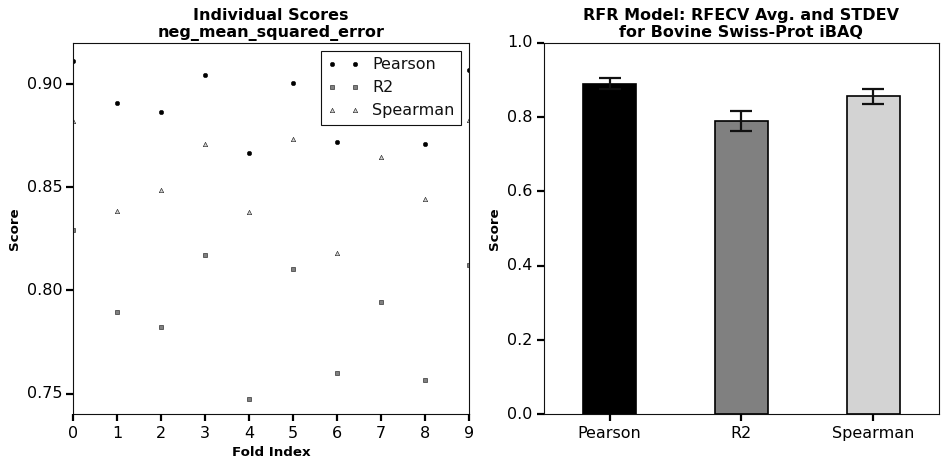

Scorer ran successfully
                                Feature  Importance
0                    Abundance_Controls   46.699088
1                                  Mass    0.800769
2                             frac_aa_A    1.165870
3                             frac_aa_C    0.626946
4                             frac_aa_D    0.758448
..                                  ...         ...
56                                 Dtem    1.781855
57                    Dh_functionalized    3.167899
58                          Centrifuged    0.540178
59  NP_incubation Concentration (mg/mL)    1.231730
60     Incubation Concentration (mg/ml)    2.103297

[61 rows x 2 columns]


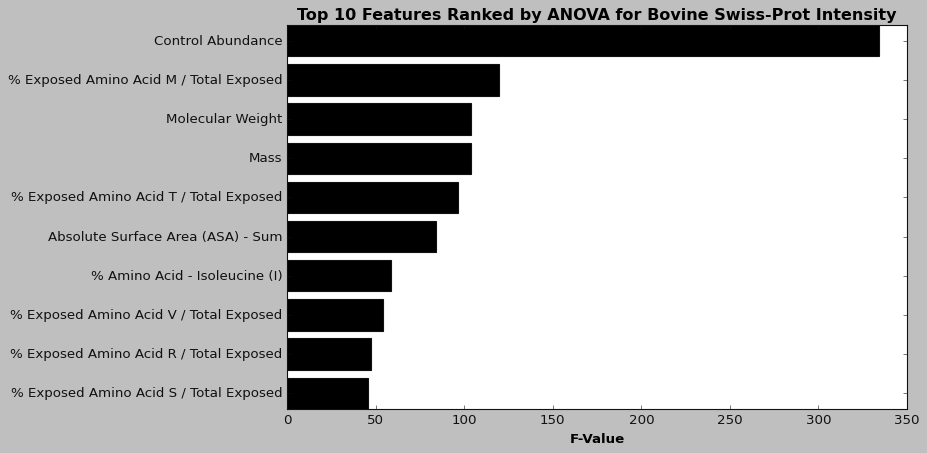

                                   Feature     F-Value       P-Value
0                        Control Abundance  333.944139  1.229467e-70
39  % Exposed Amino Acid M / Total Exposed  119.440101  2.891759e-27
16                        Molecular Weight  103.858382  5.570276e-24
1                                     Mass  103.858065  5.571136e-24
43  % Exposed Amino Acid T / Total Exposed   96.359569  2.159723e-22
29       Absolute Surface Area (ASA) - Sum   84.258548  8.110699e-20
7            % Amino Acid - Isoleucine (I)   58.786317  2.394101e-14
44  % Exposed Amino Acid V / Total Exposed   53.889169  2.753227e-13
41  % Exposed Amino Acid R / Total Exposed   47.263004  7.595899e-12
42  % Exposed Amino Acid S / Total Exposed   45.761411  1.614496e-11


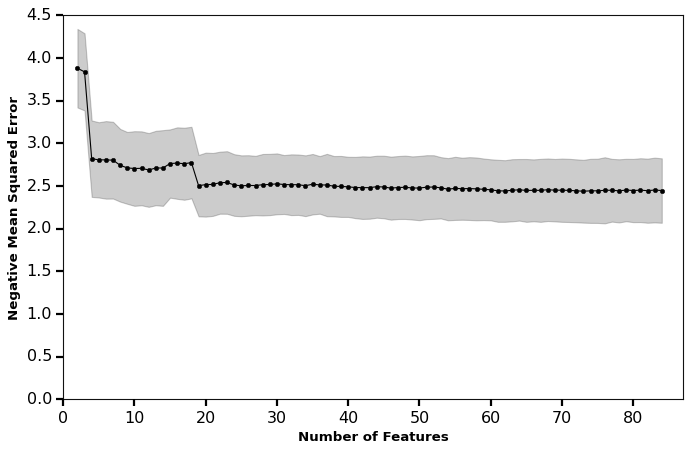

Bov SP Intensity done


In [ ]:
def process_file(train_df, name):
    # Initialize RFR model
    model = RandomForestRegressor(n_estimators=100, random_state = 42)

    # Save a copy of the original df
    train_df_original = train_df.copy()

    # 'Abundance' column in train_df represents target value
    y_label = np.log2(train_df['Abundance'].to_numpy().astype(float))

    # Remove columns in train_df that should not be considered as potential features during feature selection
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'NPID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'BatchID', 'Protein Source'] if col in train_df.columns]
    train_df.drop(columns=columns_to_drop, inplace=True)
    print(train_df.columns)

    # RFECV Variables
    identifier = 'neg_mean_squared_error'
    keep_columns = ['Abundance', 'NPUNID', 'Entry']
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Define feature range
    max_features = train_df.shape[1]  # equal to the number of columns in train_df
    min_features = 1

    selected_features = None
    current_score = float(100)

    df_full_results = pd.DataFrame({"Number of features": [],
                                    "Avg neg_mean_squared_err": [],
                                    "Std dev": [],
                                    "List of features": [],
                                    "Combined Score": []})
    print('start', name)

    for n_features_to_select in range(max_features, min_features, -1):
        print('n_features_to_select', n_features_to_select)
        avg_accuracies = []

        # Dictionary with feature name keys
        feat_dict = {key: 0 for key in train_df.columns}

        for train_index, test_index in kf.split(train_df):

            assert len(set(train_index) & set(test_index)) == 0, "Overlap found between training and testing sets"

            X_train, X_test = train_df.iloc[train_index], train_df.iloc[test_index]
            y_train, y_test = y_label[train_index], y_label[test_index]

            # Train RFR model
            model.fit(X_train, y_train)

            # Evaluate on test split
            y_pred = model.predict(X_test)
            accuracy = mean_squared_error(y_pred, y_test)
            avg_accuracies.append(accuracy)

            for idx, feature in enumerate(train_df.columns):
                feat_dict[feature] += model.feature_importances_[idx]

        # Compute average accuracy across all folds
        avg_accuracy = np.mean(avg_accuracies)
        std_dev = np.std(avg_accuracies)

        # If this is the best combo, save it
        combined_score = avg_accuracy + std_dev + (n_features_to_select / 5000)
        df_full_results.loc[len(df_full_results)] = [n_features_to_select, avg_accuracy, std_dev, ", ".join(train_df.columns), combined_score]

        # Drop the feature with the lowest importance sum
        train_df = train_df[[key for key in feat_dict if key != min(feat_dict, key=feat_dict.get)]]

        if combined_score < current_score:
            current_score = combined_score
            # Selecting the best features of the current train_df
            best_features = train_df.columns.tolist()

    print("Best Feature Names:", best_features)

    # Save RFECV results and scores
    df_full_results.to_csv(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/RFECV_RFR_results_{name}.csv', index=False)
    feat_list = best_features + keep_columns

    # Run scorer to determine feature importance and metrics for each train_df
    train_df = train_df_original[best_features].copy()
    RFR_scores, feats = scorer(train_df, y_label, model, identifier=identifier, folds=n_splits)

    feats.to_excel(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Feats_RFECV_{name}.xlsx', index=False)
    RFR_scores.to_excel(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Scores_RFECV_{name}.xlsx', index=False)

    train_df_RFECV = train_df_original[feat_list].copy()
    train_df_RFECV.to_csv(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_{name}.csv', index=False)

    # Compute feature importances and print them
    feature_importances = model.feature_importances_
    normalized_importances = 100.0 * (feature_importances / feature_importances.sum())
    feature_importance_df = pd.DataFrame({'Feature': best_features, 'Importance': normalized_importances})
    feature_importance_df.to_excel(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/feature_importance_df_{name}.xlsx', index=False)
    print(feature_importance_df)

    # Calculate ANOVA
    ranked_features = rank_features_by_anova(train_df[best_features], y_label, best_features)
    top_10_features = ranked_features.head(10)
    top_10_features.to_csv(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/ANOVA_top_features_{name}.csv')
    plot_top_features(top_10_features, name)
    print(top_10_features)

    # Plot RFECV results
    plt.style.use('classic')
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    n_features = df_full_results["Number of features"]
    mse_mean = df_full_results["Avg neg_mean_squared_err"]
    mse_std = df_full_results["Std dev"]

    ax.plot(n_features, mse_mean, label='Negative MSE', color='black', marker='o', markersize=4)
    ax.fill_between(n_features, mse_mean - mse_std, mse_mean + mse_std, color='black', alpha=0.2)

    ax.set_xlabel('Number of Features', fontweight='bold', color='black')
    ax.set_ylabel('Negative Mean Squared Error', fontweight='bold', color='black')

    ax.set_ylim(0, None) # optional, just plot manipulation
    ax.set_xlim(0, 87) # optional, just plot manipulation
    ax.tick_params(axis='both', which='both', direction='out',
                   length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black',
                   bottom=True, top=False, left=True, right=False)
    ax.grid(False)

    plt.savefig(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/RFECV_plot_{name}.png')
    plt.savefig(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/RFECV_plot_{name}.svg')
    plt.show()
    plt.close()

    print(name, 'done')

# Call the function with the training data
train_df = pd.read_excel('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/train_data_Bov SP Intensity_v1.xlsx')
process_file(train_df, "Bov SP Intensity")

## Predicting on Test Data Split
### Link to previously split testing
Link Excel file from RFECV section: **df_RFECV_RFR_{name}**
to only use features in predictions selected through model training (selected features correspond to columns in df)

Saving .csv result file to .xlsx file type (not necessary, but helpful for external data analysis)

In [ ]:
def convert_csv_to_xlsx(csv_file, xlsx_file):
    df = pd.read_csv(csv_file)
    df.to_excel(xlsx_file, index=False)

convert_csv_to_xlsx('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_Bov SP Intensity.csv','/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_Bov SP Intensity.xlsx')

 98%|===================| 312/318 [00:29<00:00]       

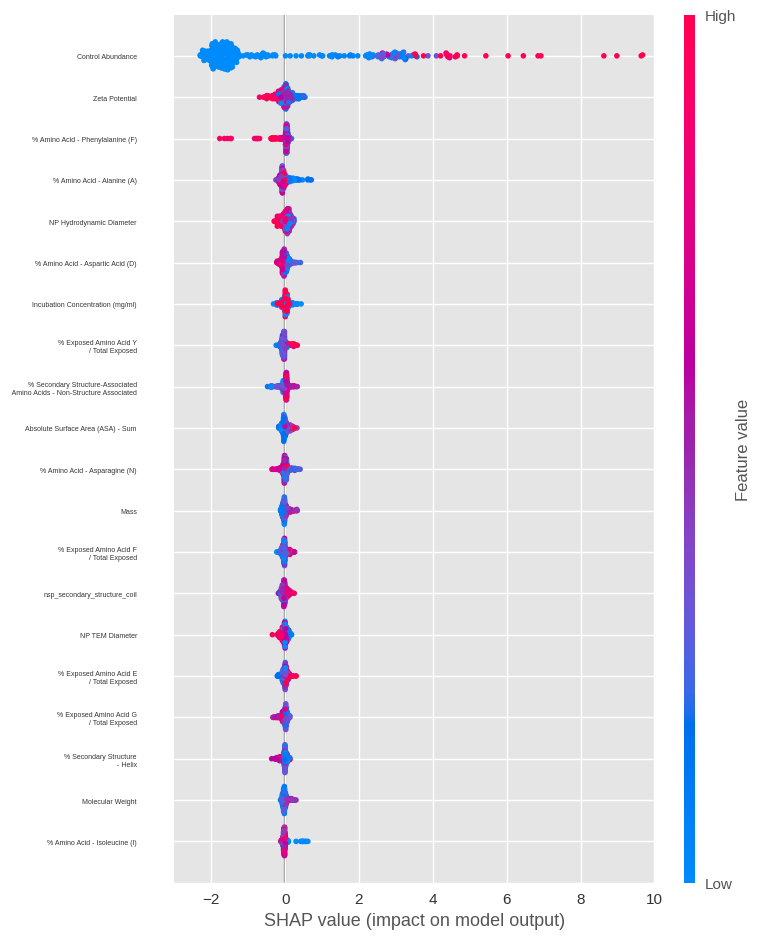

Pearson: 0.8981206869110825
Spearman: 0.8746051651276916
R-squared: 0.8061869600979554
Mean Squared Error: 2.01978881390117


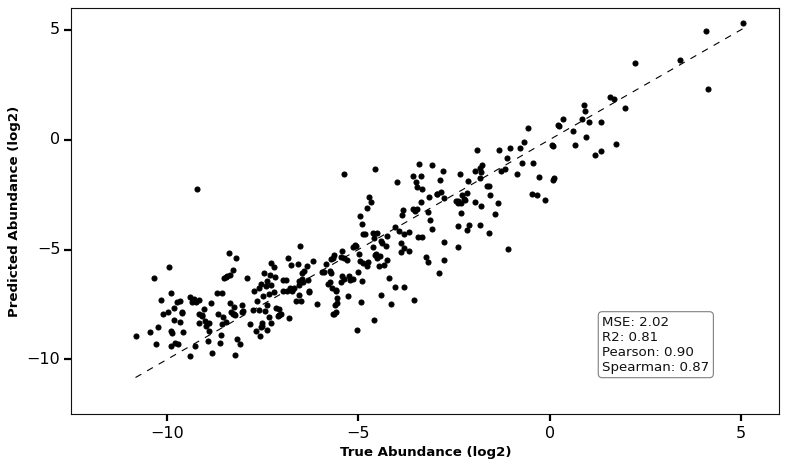

Model evaluation for Bovine SP Intensity prediction is complete!


In [ ]:
def predict_file(train_file, test_file, name):
    # Initialize RFR model
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Read the input training df
    df_train = pd.read_excel(train_file, header=0)

    # Log-transform the 'Abundance' target variable for training
    y_train = np.log2(df_train['Abundance'].to_numpy().astype(float))

    # Drop unnecessary columns in both training and test sets
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry']
    df_train.drop(columns=[col for col in columns_to_drop if col in df_train.columns], inplace=True)

    # Read the input test DataFrame
    df_test = pd.read_excel(test_file, header=0)
    #Min_Abundance = df_test['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    #df_test = df_test[df_test['Abundance'] >= Min_Abundance]

    # Log-transform the 'Abundance' target variable for testing
    y_test = np.log2(df_test['Abundance'].to_numpy().astype(float))

    selected_features = df_train.columns

    X_train = df_train[selected_features].copy()
    X_test = df_test[selected_features].copy()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    feature_name_dict = {
          'Abundance_Controls' : 'Control Abundance',
          'frac_aa_A': '% Amino Acid - Alanine (A)',
          'frac_aa_C': '% Amino Acid - Cysteine (C)',
          'frac_aa_D': '% Amino Acid - Aspartic Acid (D)',
          'frac_aa_E': '% Amino Acid - Glutamic Acid (E)',
          'frac_aa_F': '% Amino Acid - Phenylalanine (F)',
          'frac_aa_G': '% Amino Acid - Glycine (G)',
          'frac_aa_H': '% Amino Acid - Histidine (H)',
          'frac_aa_I': '% Amino Acid - Isoleucine (I)',
          'frac_aa_K': '% Amino Acid - Lysine (K)',
          'frac_aa_L': '% Amino Acid - Leucine (L)',
          'frac_aa_M': '% Amino Acid - Methionine (M)',
          'frac_aa_N': '% Amino Acid - Asparagine (N)',
          'frac_aa_P': '% Amino Acid - Proline (P)',
          'frac_aa_Q': '% Amino Acid - Glutamine (Q)',
          'frac_aa_R': '% Amino Acid - Arginine (R)',
          'frac_aa_S': '% Amino Acid - Serine (S)',
          'frac_aa_T': '% Amino Acid - Threonine (T)',
          'frac_aa_V': '% Amino Acid - Valine (V)',
          'frac_aa_W': '% Amino Acid - Tryptophan (W)',
          'frac_aa_Y': '% Amino Acid - Tyrosine (Y)',
          'gravy': 'GRAVY score',
          'aromaticity': 'Aromaticity',
          'instability_index': 'Instability Index',
          'flexibility_mean': 'Flexibility - Mean',
          'flexibility_std': 'Flexibility - Standard Deviation',
          'flexibility_max': 'Flexibility - Max',
          'flexibility_min': 'Flexibility - Min',
          'isoelectric_point': 'Isoelectric Point',
          'secondary_structure_fraction_helix': '% Secondary Structure-Associated\n Amino Acids – Helix',
          'secondary_structure_fraction_turn': '% Secondary Structure-Associated\n Amino Acids – Turn',
          'secondary_structure_fraction_sheet': '% Secondary Structure-Associated\n Amino Acids – Sheet',
          'secondary_structure_fraction_disordered': '% Secondary Structure-Associated\n Amino Acids - Non-Structure Associated',
          'length': 'Length',
          'molecular_weight': 'Molecular Weight',
          'fraction_exposed': '% Amino Acids Exposed',
          'fraction_buried': '% Amino Acids Buried',
          'fraction_exposed_nonpolar_total': '% Exposed Nonpolar Amino Acids\n / Total Amino Acids',
          'fraction_exposed_nonpolar_exposed': '% Exposed Nonpolar Amino Acids\n / Total Exposed',
          'fraction_exposed_polar_total': '% Exposed Polar Amino Acids\n / Total Amino Acids',
          'fraction_exposed_polar_exposed': '% Exposed Polar Amino Acids\n / Total Exposed',
          'rsa_mean': 'Relative Surface Area (RSA) - Mean',
          'rsa_std': 'Relative Surface Area - Standard Deviation',
          'asa_sum': 'Absolute Surface Area (ASA) - Sum',
          'fraction_exposed_exposed_A': '% Exposed Amino Acid A\n / Total Exposed',
          'fraction_exposed_exposed_C': '% Exposed Amino Acid C\n / Total Exposed',
          'fraction_exposed_exposed_D': '% Exposed Amino Acid D\n / Total Exposed',
          'fraction_exposed_exposed_E': '% Exposed Amino Acid E\n / Total Exposed',
          'fraction_exposed_exposed_F': '% Exposed Amino Acid F\n / Total Exposed',
          'fraction_exposed_exposed_G': '% Exposed Amino Acid G\n / Total Exposed',
          'fraction_exposed_exposed_H': '% Exposed Amino Acid H\n / Total Exposed',
          'fraction_exposed_exposed_I': '% Exposed Amino Acid I\n / Total Exposed',
          'fraction_exposed_exposed_K': '% Exposed Amino Acid K\n / Total Exposed',
          'fraction_exposed_exposed_L': '% Exposed Amino Acid L\n / Total Exposed',
          'fraction_exposed_exposed_M': '% Exposed Amino Acid M\n / Total Exposed',
          'fraction_exposed_exposed_N': '% Exposed Amino Acid N\n / Total Exposed',
          'fraction_exposed_exposed_P': '% Exposed Amino Acid P\n / Total Exposed',
          'fraction_exposed_exposed_Q': '% Exposed Amino Acid Q\n / Total Exposed',
          'fraction_exposed_exposed_R': '% Exposed Amino Acid R\n / Total Exposed',
          'fraction_exposed_exposed_S': '% Exposed Amino Acid S\n / Total Exposed',
          'fraction_exposed_exposed_T': '% Exposed Amino Acid T\n / Total Exposed',
          'fraction_exposed_exposed_V': '% Exposed Amino Acid V\n / Total Exposed',
          'fraction_exposed_exposed_W': '% Exposed Amino Acid W\n / Total Exposed',
          'fraction_exposed_exposed_Y': '% Exposed Amino Acid Y\n / Total Exposed',
          'nsp_secondary_structure_helix': '% Secondary Structure\n - Helix',
          'nsp_secondary_structure_sheet': '% Secondary Structure\n - Sheet',
          'nsp_secondary_structure_coiled': '% Secondary Structure\n - Coil',
          'nsp_disordered': '% Secondary Structure - Disordered',
          'Dh_functionalized': 'NP Hydrodynamic Diameter',
          'Dtem': 'NP TEM Diameter'
    }

    original_column_names = X_test.columns

    # SHAP evaluation of feature section
    X_train_graph = X_train.copy()
    X_test_graph = X_test.copy()
    X_train_graph.columns = [feature_name_dict.get(col, col) for col in original_column_names]
    X_test_graph.columns = [feature_name_dict.get(col, col) for col in original_column_names]


    #explainer = shap.Explainer(model, X_train_graph)
    explainer = shap.TreeExplainer(model, X_train_graph)
    shap_values = explainer(X_test_graph, check_additivity=False)
    shap.summary_plot(shap_values, X_test_graph, show=False)
    plt.xlim(-3, 10) # originally -4 to +12
    #plt.grid(False)

    plt.gca().tick_params(axis='y', labelsize=5)
    plt.tight_layout()
    plt.show()

    # Calculate evaluation metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print("Pearson:", pearson)
    print("Spearman:", spearman)
    print("R-squared:", r_squared)
    print("Mean Squared Error:", mse)

    # Create a scatter plot of true vs predicted values
    plt.style.use('classic')

    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    plt.rcParams['figure.dpi'] = 300

    # Plot data
    ax.scatter(y_test, y_pred, color='black', s=20)  # Adjust marker size with `s`
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Identity line

    ax.set_xlabel('True Abundance (log2)', fontweight='bold', color='black')
    ax.set_ylabel('Predicted Abundance (log2)', fontweight='bold', color='black')

    ax.tick_params(axis='both', which='both', direction='out',
               length=6, width=2, colors='black',
               labelsize='large', labelcolor='black',
               bottom=True, top=False, left=True, right=False)
    ax.set_xlim(left=-12.5, right=6)
    ax.set_ylim(bottom=-12.5, top=6)

    # Add a metrics box to the plot
    box_text = f"MSE: {mse:.2f}\nR2: {r_squared:.2f}\nPearson: {pearson:.2f}\nSpearman: {spearman:.2f}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='black')
    ax.text(0.75, 0.10, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

    # Remove grid lines
    ax.grid(False)

    plt.tight_layout()
    plt.show()
    plt.close()

    print(f"Model evaluation for {name} is complete!")


# Call the function for a single file without threading
predict_file('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_Bov SP Intensity.xlsx',
             '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/test_data_Bov SP Intensity_v1.xlsx',
             'Bovine SP Intensity prediction')


## Adversarial Testing

Pearson: 0.03852255150268491
Spearman: 0.024657996361240626
R-squared: -0.01107059324377424
Mean Squared Error: 10.53669595879783


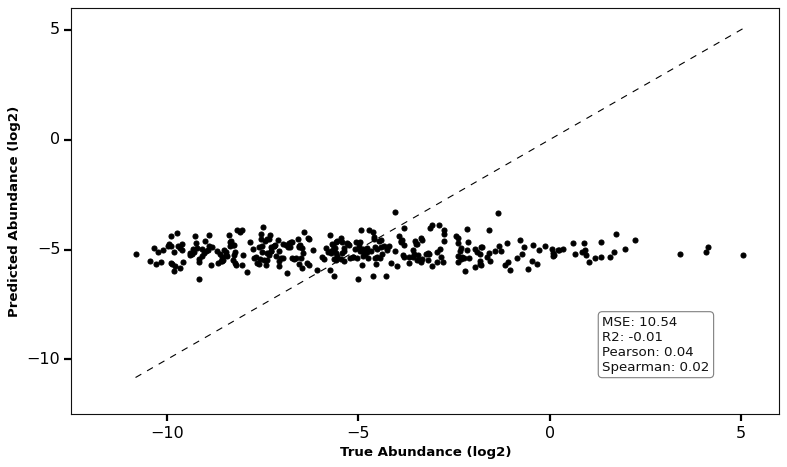

X-Shuffling adversarial test completed. Results saved at: /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/X_shuffling_results.xlsx


In [ ]:
def predict_x_shuffled(train_file, test_file, name):

    df_train = pd.read_excel(train_file, header=0)
    df_test = pd.read_excel(test_file, header=0)

    # Log-transform the 'Abundance' target variable
    y_train = np.log2(df_train['Abundance'].to_numpy().astype(float))
    y_test = np.log2(df_test['Abundance'].to_numpy().astype(float))

    # Drop unnecessary columns
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry']
    df_train.drop(columns=[col for col in columns_to_drop if col in df_train.columns], inplace=True)
    df_test.drop(columns=[col for col in columns_to_drop if col in df_test.columns], inplace=True)

    # Select features
    selected_features = df_train.columns

    # Copy feature data
    X_train = df_train[selected_features].copy()
    X_test = df_test[selected_features].copy()

    # X-Shuffling (for adversarial control)
    np.random.seed(42)
    for col in X_train.columns:
        X_train[col] = np.random.permutation(X_train[col].values)  # Shuffle each column independently, changed shuffle to permutation
        X_test[col] = np.random.permutation(X_test[col].values)   # Also shuffle test set, changed shuffle to permutation

    #Initialize and train RFR
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict on test split
    y_pred = model.predict(X_test)

    # Evaluation Metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print("Pearson:", pearson)
    print("Spearman:", spearman)
    print("R-squared:", r_squared)
    print("Mean Squared Error:", mse)


    results = pd.DataFrame({
        "Name": [name + " (X-Shuffled)"],
        "Pearson": [pearson],
        "Spearman": [spearman],
        "R-squared": [r_squared],
        "MSE": [mse]
    })

    # Create a scatter plot of true vs predicted values
    plt.style.use('classic')

    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    plt.rcParams['figure.dpi'] = 300

    # Plot data
    ax.scatter(y_test, y_pred, color='black', s=20)  # Adjust marker size with `s`
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Identity line

    ax.set_xlabel('True Abundance (log2)', fontweight='bold', color='black')
    ax.set_ylabel('Predicted Abundance (log2)', fontweight='bold', color='black')

    # Setting plot title
    #ax.set_title(f'RFR Model: Predicted vs True Abundance (Log) Bov Swiss-Prot Intensity', fontweight='bold', color='black')

    ax.tick_params(axis='both', which='both', direction='out',
               length=6, width=2, colors='black',
               labelsize='large', labelcolor='black',
               bottom=True, top=False, left=True, right=False)
    ax.set_xlim(left=-12.5, right=6)
    ax.set_ylim(bottom=-12.5, top=6)

    # Add a metrics box to the plot
    box_text = f"MSE: {mse:.2f}\nR2: {r_squared:.2f}\nPearson: {pearson:.2f}\nSpearman: {spearman:.2f}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='black')
    ax.text(0.75, 0.10, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

    # Remove grid lines
    ax.grid(False)

    plt.tight_layout()
    plt.show()

    plt.close()

    output_results_path = "/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/X_shuffling_results.xlsx"
    #results.to_excel(output_results_path, index=False)

    print(f"X-Shuffling adversarial test completed. Results saved at: {output_results_path}")

    return results



x_shuffled_results = predict_x_shuffled('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_Bov SP Intensity.xlsx',
             '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/test_data_Bov SP Intensity_v1.xlsx',
             'Bovine SP Intensity prediction'
)


Adversiral Testing - Y-Shuffle

In [ ]:
def predict_y_shuffled(train_file, test_file, name):

    df_train = pd.read_excel(train_file, header=0)
    df_test = pd.read_excel(test_file, header=0)

    # Log-transform the 'Abundance' target variable
    y_train = np.log2(df_train['Abundance'].to_numpy().astype(float))
    y_test = np.log2(df_test['Abundance'].to_numpy().astype(float))

    # Drop unnecessary columns
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry']
    df_train.drop(columns=[col for col in columns_to_drop if col in df_train.columns], inplace=True)
    df_test.drop(columns=[col for col in columns_to_drop if col in df_test.columns], inplace=True)

    # Select features
    selected_features = df_train.columns

    # Copy feature data
    X_train = df_train[selected_features].copy()
    X_test = df_test[selected_features].copy()

    y_train = np.random.permutation(y_train)

    #Initialize and train RFR
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict on test split
    y_pred = model.predict(X_test)

    # Evaluation Metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print("Pearson:", pearson)
    print("Spearman:", spearman)
    print("R-squared:", r_squared)
    print("Mean Squared Error:", mse)


    results = pd.DataFrame({
        "Name": [name + " (X-Shuffled)"],
        "Pearson": [pearson],
        "Spearman": [spearman],
        "R-squared": [r_squared],
        "MSE": [mse]
    })

    output_results_path = "/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/y_shuffling_results.xlsx"
    #results.to_excel(output_results_path, index=False)

    print(f"Y-Shuffling adversarial test completed. Results saved at: {output_results_path}")

    return results



y_shuffled_results = predict_y_shuffled(
              '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_Bov SP Intensity.xlsx',
             '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/test_data_Bov SP Intensity_v1.xlsx',
             'Bovine SP Intensity prediction'
)


Pearson: -0.05826024058894407
Spearman: -0.04469822758348277
R-squared: -0.22681303999529612
Mean Squared Error: 12.785018263905002
Y-Shuffling adversarial test completed. Results saved at: /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/y_shuffling_results.xlsx


### Extracting Predicted vs True Abundances (log2) for a subset of Proteins

Pearson: 0.8336339030209394
Spearman: 0.7522157713313865
R-squared: 0.6835268982874991
Mean Squared Error: 3.3667162467502307
Predictions saved to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/protein_abundance_predictions_comparison_withSampleNum_32.xlsx


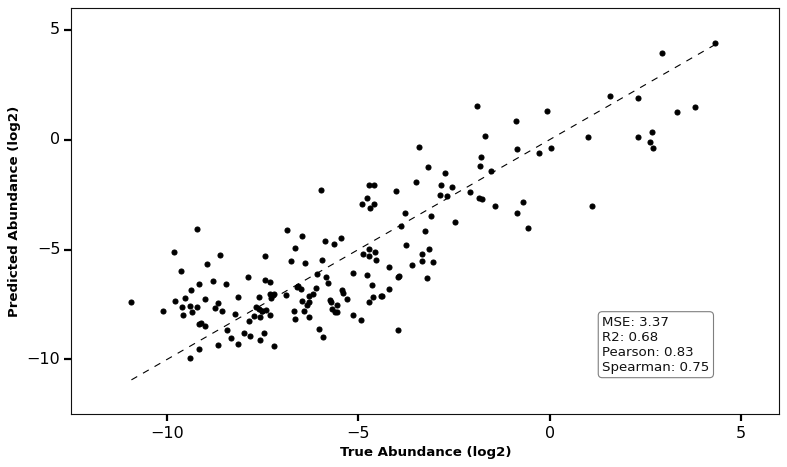

Model evaluation for Bovine SP Intensity predict on 32 only is complete!


In [ ]:
def predict_file(train_file, test_file, name):
    # Initialize a RandomForestRegressor model with 100 estimators
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Read the input training DataFrame
    df_train = pd.read_excel(train_file, header=0)

    # Log-transform the 'Abundance' target variable for training
    y_train = np.log2(df_train['Abundance'].to_numpy().astype(float))

    # Drop unnecessary columns in both training and test sets
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry']
    df_train.drop(columns=[col for col in columns_to_drop if col in df_train.columns], inplace=True)

    # Read the input test DataFrame
    df_test = pd.read_excel(test_file, header=0)

    # Log-transform the 'Abundance' target variable for testing
    y_test = np.log2(df_test['Abundance'].to_numpy().astype(float))

    # Store relevant columns: proteins and sample identifiers
    proteins = df_test['Entry'] if 'Entry' in df_test.columns else None
    sample_num = df_test['Sample_num'] if 'Sample_num' in df_test.columns else None

    selected_features = df_train.columns

    X_train = df_train[selected_features].copy()
    X_test = df_test[selected_features].copy()

    # Fit the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print("Pearson:", pearson)
    print("Spearman:", spearman)
    print("R-squared:", r_squared)
    print("Mean Squared Error:", mse)

    # Save true and predicted abundance values along with Sample_num to an Excel file
    results = pd.DataFrame({
        'Sample_num': sample_num,  # NP identifier
        'Protein': proteins,       # Protein identifiers
        'True Abundance (log)': y_test,
        'Predicted Abundance (log)': y_pred
    })

    output_path = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/protein_abundance_predictions_comparison_withSampleNum_32.xlsx'
    results.to_excel(output_path, index=False)
    print(f"Predictions saved to {output_path}")

    # Create the scatter plot (as in your existing code)
    plt.style.use('classic')
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
    plt.rcParams['figure.dpi'] = 300
    ax.scatter(y_test, y_pred, color='black', s=20)
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')
    ax.set_xlabel('True Abundance (log2)', fontweight='bold', color='black')
    ax.set_ylabel('Predicted Abundance (log2)', fontweight='bold', color='black')
    ax.tick_params(axis='both', which='both', direction='out', length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black', bottom=True, top=False, left=True, right=False)
    ax.set_xlim(left=-12.5, right=6)
    ax.set_ylim(bottom=-12.5, top=6)
    box_text = f"MSE: {mse:.2f}\nR2: {r_squared:.2f}\nPearson: {pearson:.2f}\nSpearman: {spearman:.2f}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='black')
    ax.text(0.75, 0.10, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)
    ax.grid(False)
    plt.tight_layout()
    plt.show()
    plt.close()

    print(f"Model evaluation for {name} is complete!")


# Call the function for a single file without threading
#predict_file('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_Bov SP Intensity training_data_original.xlsx', '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/test_data_Bov SP Intensity_original.xlsx', 'Bovine SP Intensity')
predict_file('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_Bov SP Intensity training_data_no_32_no_49.xlsx', '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/df_Bov Swiss Intensity_only_32.xlsx', 'Bovine SP Intensity predict on 32 only')



## NP-Specific Predictions

[18, 28, 25, 17, 31, 23, 29, 34, 27, 21, 22, 19, 24, 30, 20, 33, 32, 26]
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fract

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


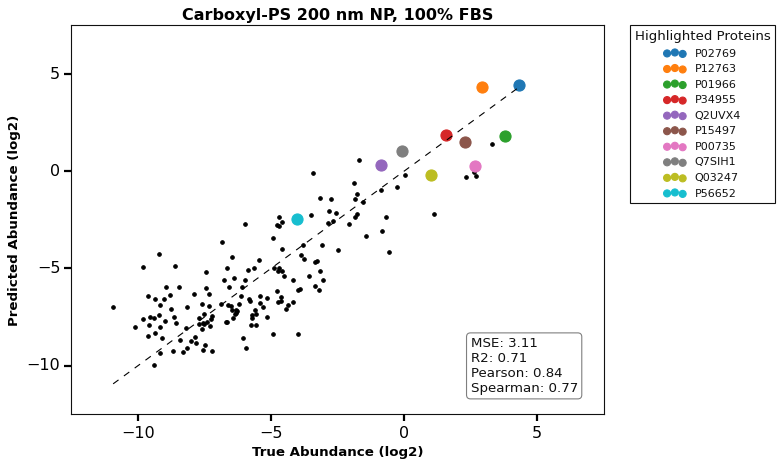

Saved parity plot data for Carboxyl-PS 200 nm NP, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Carboxyl-PS 200 nm NP, 100% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


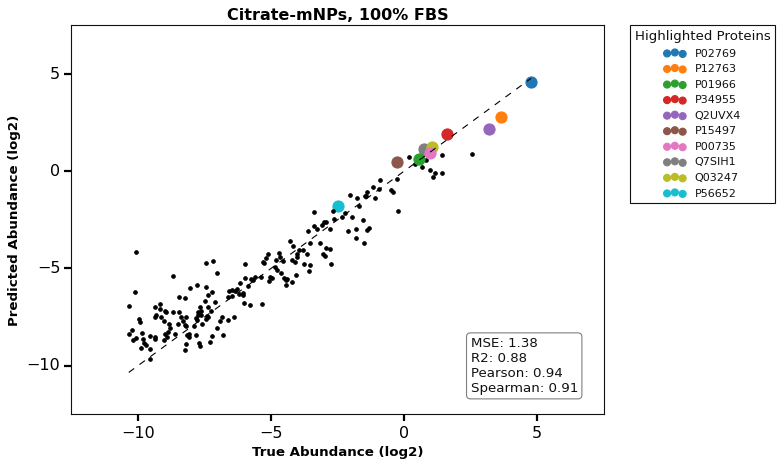

Saved parity plot data for Citrate-mNPs, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Citrate-mNPs, 100% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std',

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


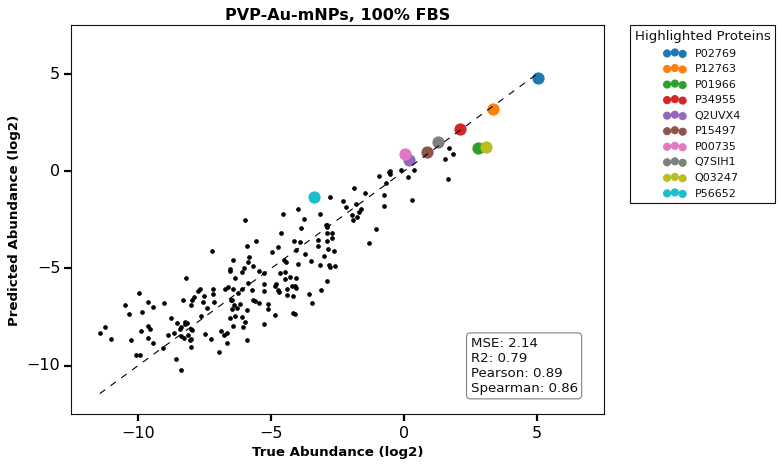

Saved parity plot data for PVP-Au-mNPs, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PVP-Au-mNPs, 100% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std', '

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


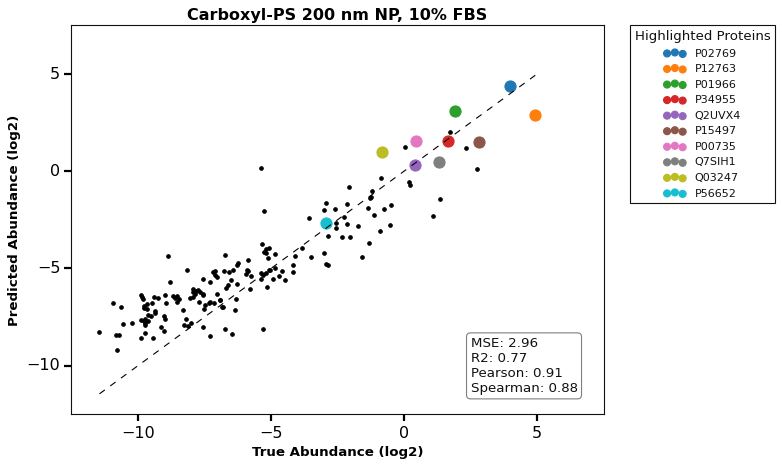

Saved parity plot data for Carboxyl-PS 200 nm NP, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Carboxyl-PS 200 nm NP, 10% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_m

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


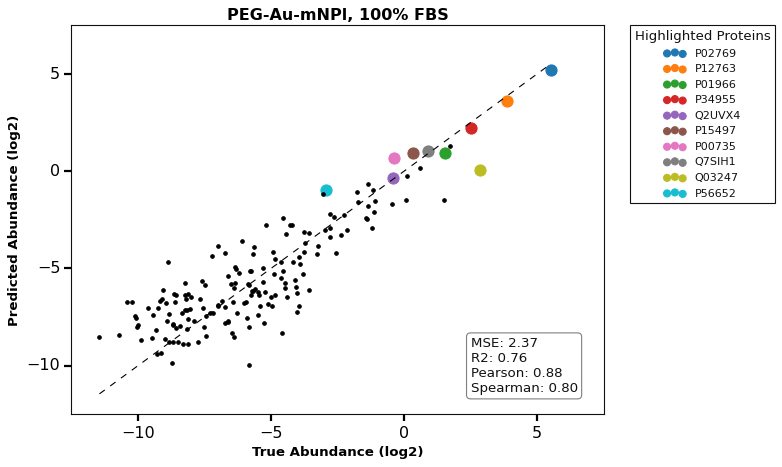

Saved parity plot data for PEG-Au-mNPl, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEG-Au-mNPl, 100% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std', '

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


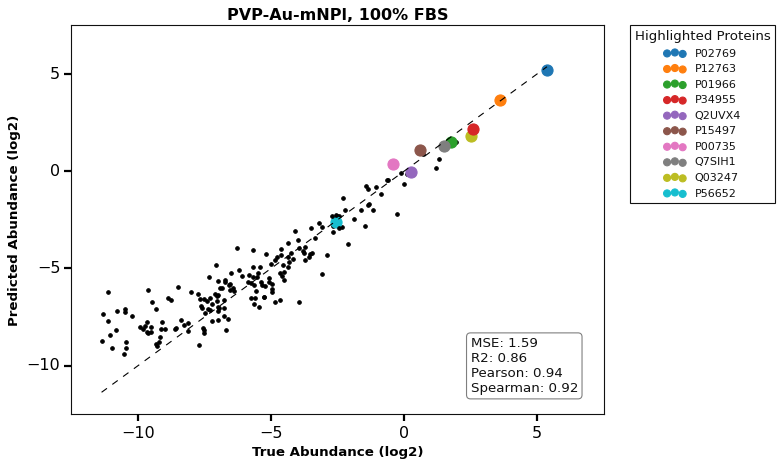

Saved parity plot data for PVP-Au-mNPl, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PVP-Au-mNPl, 100% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std', '

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


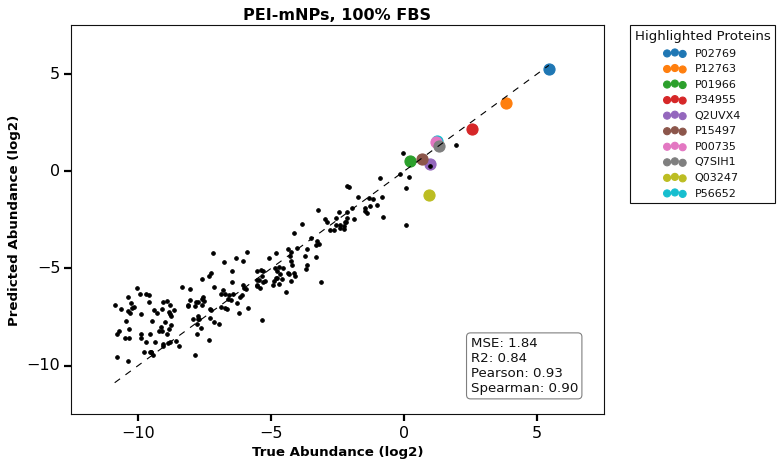

Saved parity plot data for PEI-mNPs, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEI-mNPs, 100% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std', 'asa_su

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


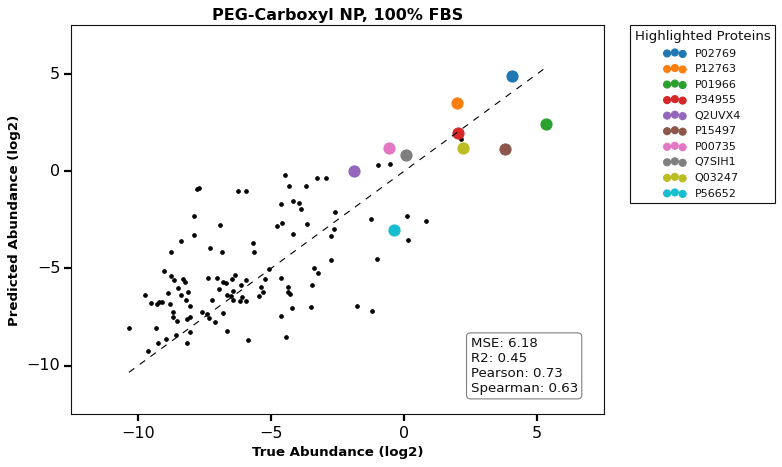

Saved parity plot data for PEG-Carboxyl NP, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEG-Carboxyl NP, 100% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


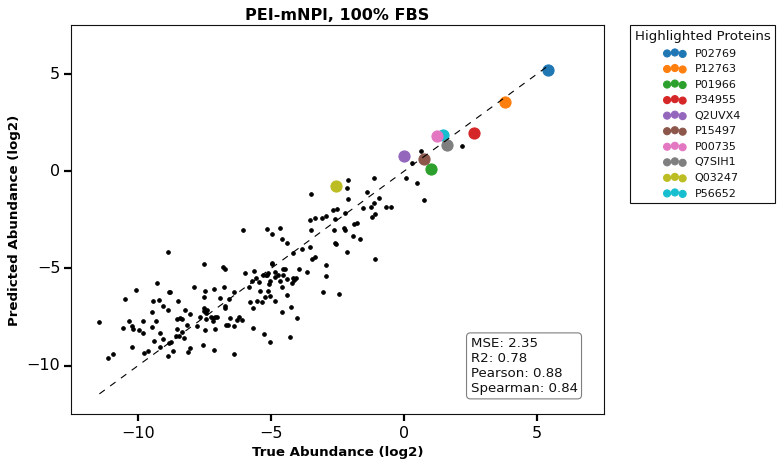

Saved parity plot data for PEI-mNPl, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEI-mNPl, 100% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std', 'asa_su

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


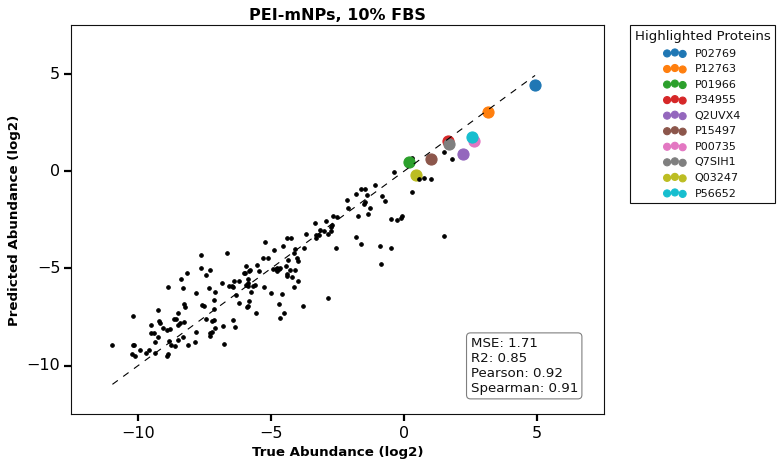

Saved parity plot data for PEI-mNPs, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEI-mNPs, 10% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std', 'asa_sum'

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


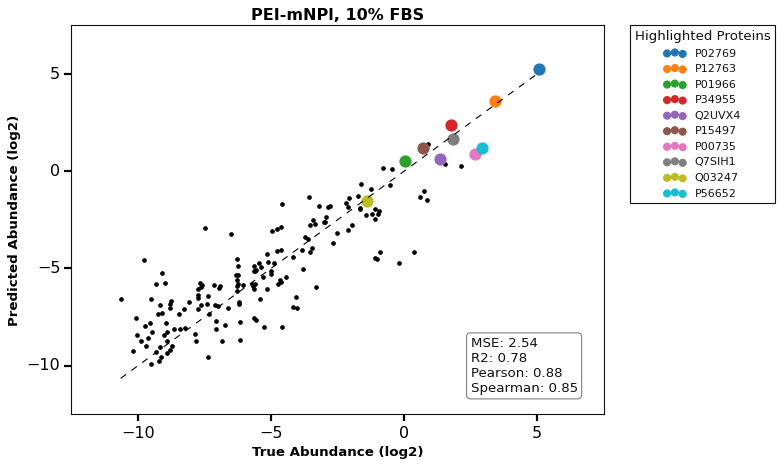

Saved parity plot data for PEI-mNPl, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEI-mNPl, 10% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std', 'asa_sum'

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


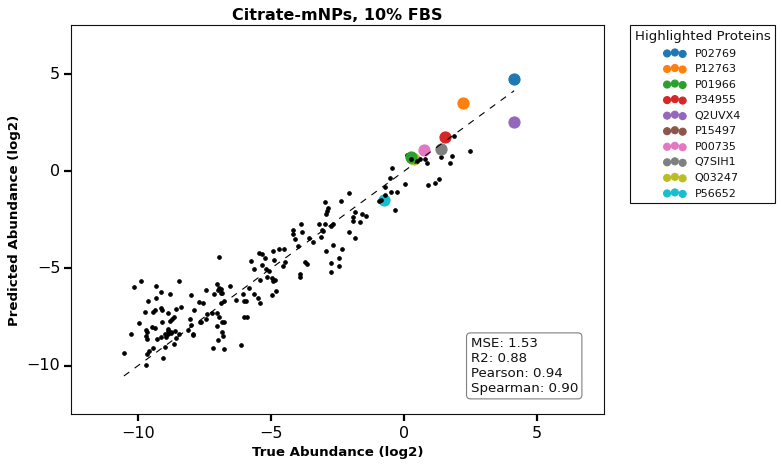

Saved parity plot data for Citrate-mNPs, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Citrate-mNPs, 10% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std', '

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


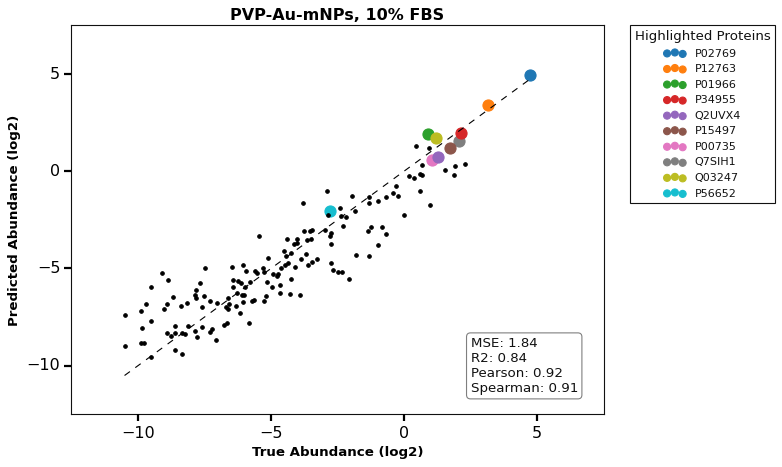

Saved parity plot data for PVP-Au-mNPs, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PVP-Au-mNPs, 10% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std', 'as

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


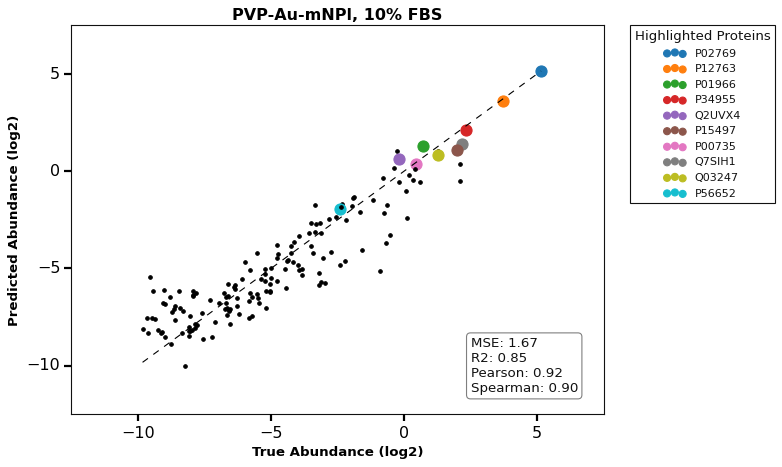

Saved parity plot data for PVP-Au-mNPl, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PVP-Au-mNPl, 10% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std', 'as

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


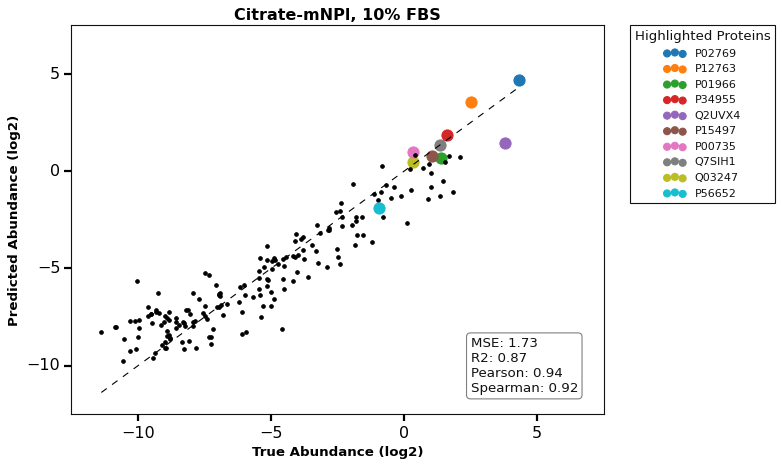

Saved parity plot data for Citrate-mNPl, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Citrate-mNPl, 10% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std', '

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


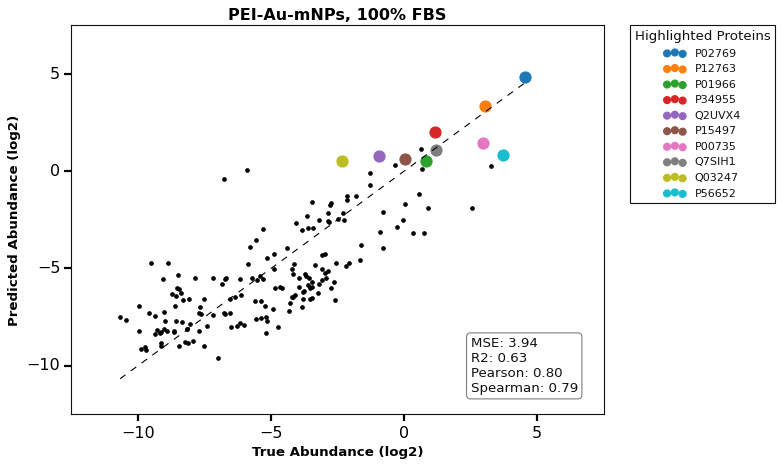

Saved parity plot data for PEI-Au-mNPs, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEI-Au-mNPs, 100% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std', '

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


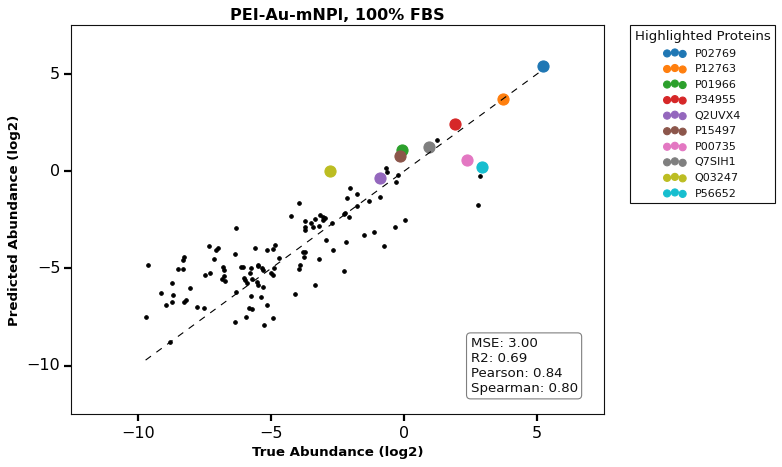

Saved parity plot data for PEI-Au-mNPl, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEI-Au-mNPl, 100% FBS_parity_plot_data_predict.xlsx
['Abundance_Controls', 'Length', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M', 'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'aromaticity', 'instability_index', 'flexibility_mean', 'flexibility_std', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_turn', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'gravy', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'fraction_exposed_polar_total', 'fraction_exposed_polar_exposed', 'rsa_mean', 'rsa_std', '

<ipython-input-5-f7aff2acabd6>:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))


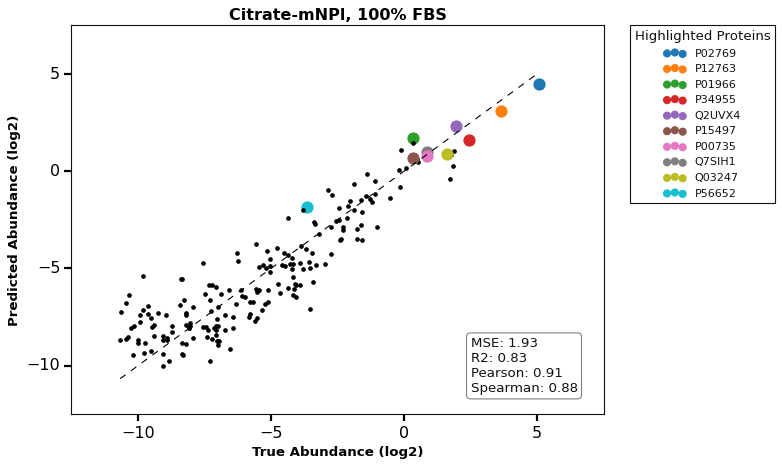

Saved parity plot data for Citrate-mNPl, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Citrate-mNPl, 100% FBS_parity_plot_data_predict.xlsx
    Pearson  Spearman  R-squared  Mean Squared Error  \
0  0.844641  0.766601   0.707965            3.106742   
0  0.944487  0.911787   0.883785            1.376856   
0  0.890983  0.862184   0.792102            2.140087   
0  0.912216  0.883095   0.769032            2.964916   
0  0.875386  0.804942   0.763895            2.370518   

                                ID  
0  Carboxyl-PS 200 nm NP, 100% FBS  
0           Citrate-mNPs, 100% FBS  
0            PVP-Au-mNPs, 100% FBS  
0   Carboxyl-PS 200 nm NP, 10% FBS  
0            PEG-Au-mNPl, 100% FBS  


In [5]:
npunid_to_full_name = {
    17: "Carboxyl-PS 200 nm NP, 10% FBS",
    18: "Carboxyl-PS 200 nm NP, 100% FBS",
    19: "Citrate-mNPs, 10% FBS",
    20: "Citrate-mNPl, 10% FBS",
    21: "PEI-mNPs, 10% FBS",
    22: "PEI-mNPl, 10% FBS",
    23: "PVP-Au-mNPl, 100% FBS",
    24: "PVP-Au-mNPs, 10% FBS",
    25: "PVP-Au-mNPs, 100% FBS",
    26: "Citrate-mNPl, 100% FBS",
    27: "PEI-mNPl, 100% FBS",
    28: "Citrate-mNPs, 100% FBS",
    29: "PEI-mNPs, 100% FBS",
    30: "PVP-Au-mNPl, 10% FBS",
    31: "PEG-Au-mNPl, 100% FBS",
    32: "PEI-Au-mNPl, 100% FBS",
    33: "PEI-Au-mNPs, 100% FBS",
    34: "PEG-Carboxyl NP, 100% FBS"
}

def predict_nanoparticles(train_set, test_set, name):
    # Initialize a RFR
    model = RandomForestRegressor(n_estimators=100, random_state = 42)

    # X is df and y is 'Abundance' column in df
    # 'Abundance' column in df represents target value
    label_train = np.log2(train_set['Abundance'].to_numpy().astype(float))

    # Remove unnecessary columns
    #columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'Entry'] if col in train_set.columns]

    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'NPID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'BatchID', 'Protein Source'] if col in train_set.columns]
    train_set.drop(columns=columns_to_drop, inplace=True)
    selected_features = train_set.columns.tolist()
    print(selected_features)
    print(len(selected_features))

    label_pred = np.log2(test_set['Abundance'].to_numpy().astype(float))

    X_train = train_set[selected_features].copy()
    X_test = test_set[selected_features].copy()
    y_train = label_train
    y_test = label_pred

    # Train the RFR
    model.fit(X_train, y_train)

    # Evaluate on test slit (held out NP)
    y_pred = model.predict(X_test)

    # SHAP
    feature_name_dict = {
          'Abundance_Controls' : 'Control Abundance',
          'frac_aa_A': '% Amino Acid - Alanine (A)',
          'frac_aa_C': '% Amino Acid - Cysteine (C)',
          'frac_aa_D': '% Amino Acid - Aspartic Acid (D)',
          'frac_aa_E': '% Amino Acid - Glutamic Acid (E)',
          'frac_aa_F': '% Amino Acid - Phenylalanine (F)',
          'frac_aa_G': '% Amino Acid - Glycine (G)',
          'frac_aa_H': '% Amino Acid - Histidine (H)',
          'frac_aa_I': '% Amino Acid - Isoleucine (I)',
          'frac_aa_K': '% Amino Acid - Lysine (K)',
          'frac_aa_L': '% Amino Acid - Leucine (L)',
          'frac_aa_M': '% Amino Acid - Methionine (M)',
          'frac_aa_N': '% Amino Acid - Asparagine (N)',
          'frac_aa_P': '% Amino Acid - Proline (P)',
          'frac_aa_Q': '% Amino Acid - Glutamine (Q)',
          'frac_aa_R': '% Amino Acid - Arginine (R)',
          'frac_aa_S': '% Amino Acid - Serine (S)',
          'frac_aa_T': '% Amino Acid - Threonine (T)',
          'frac_aa_V': '% Amino Acid - Valine (V)',
          'frac_aa_W': '% Amino Acid - Tryptophan (W)',
          'frac_aa_Y': '% Amino Acid - Tyrosine (Y)',
          'gravy': 'GRAVY score',
          'aromaticity': 'Aromaticity',
          'instability_index': 'Instability Index',
          'flexibility_mean': 'Flexibility - Mean',
          'flexibility_std': 'Flexibility - Standard Deviation',
          'flexibility_max': 'Flexibility - Max',
          'flexibility_min': 'Flexibility - Min',
          'isoelectric_point': 'Isoelectric Point',
          'secondary_structure_fraction_helix': '% Secondary Structure-Associated\n Amino Acids – Helix',
          'secondary_structure_fraction_turn': '% Secondary Structure-Associated\n Amino Acids – Turn',
          'secondary_structure_fraction_sheet': '% Secondary Structure-Associated\n Amino Acids – Sheet',
          'secondary_structure_fraction_disordered': '% Secondary Structure-Associated\n Amino Acids - Non-Structure Associated',
          'length': 'Length',
          'molecular_weight': 'Molecular Weight',
          'fraction_exposed': '% Amino Acids Exposed',
          'fraction_buried': '% Amino Acids Buried',
          'fraction_exposed_nonpolar_total': '% Exposed Nonpolar Amino Acids\n / Total Amino Acids',
          'fraction_exposed_nonpolar_exposed': '% Exposed Nonpolar Amino Acids\n / Total Exposed',
          'fraction_exposed_polar_total': '% Exposed Polar Amino Acids\n / Total Amino Acids',
          'fraction_exposed_polar_exposed': '% Exposed Polar Amino Acids\n / Total Exposed',
          'rsa_mean': 'Relative Surface Area (RSA) - Mean',
          'rsa_std': 'Relative Surface Area - Standard Deviation',
          'asa_sum': 'Absolute Surface Area (ASA) - Sum',
          'fraction_exposed_exposed_A': '% Exposed Amino Acid A\n / Total Exposed',
          'fraction_exposed_exposed_C': '% Exposed Amino Acid C\n / Total Exposed',
          'fraction_exposed_exposed_D': '% Exposed Amino Acid D\n / Total Exposed',
          'fraction_exposed_exposed_E': '% Exposed Amino Acid E\n / Total Exposed',
          'fraction_exposed_exposed_F': '% Exposed Amino Acid F\n / Total Exposed',
          'fraction_exposed_exposed_G': '% Exposed Amino Acid G\n / Total Exposed',
          'fraction_exposed_exposed_H': '% Exposed Amino Acid H\n / Total Exposed',
          'fraction_exposed_exposed_I': '% Exposed Amino Acid I\n / Total Exposed',
          'fraction_exposed_exposed_K': '% Exposed Amino Acid K\n / Total Exposed',
          'fraction_exposed_exposed_L': '% Exposed Amino Acid L\n / Total Exposed',
          'fraction_exposed_exposed_M': '% Exposed Amino Acid M\n / Total Exposed',
          'fraction_exposed_exposed_N': '% Exposed Amino Acid N\n / Total Exposed',
          'fraction_exposed_exposed_P': '% Exposed Amino Acid P\n / Total Exposed',
          'fraction_exposed_exposed_Q': '% Exposed Amino Acid Q\n / Total Exposed',
          'fraction_exposed_exposed_R': '% Exposed Amino Acid R\n / Total Exposed',
          'fraction_exposed_exposed_S': '% Exposed Amino Acid S\n / Total Exposed',
          'fraction_exposed_exposed_T': '% Exposed Amino Acid T\n / Total Exposed',
          'fraction_exposed_exposed_V': '% Exposed Amino Acid V\n / Total Exposed',
          'fraction_exposed_exposed_W': '% Exposed Amino Acid W\n / Total Exposed',
          'fraction_exposed_exposed_Y': '% Exposed Amino Acid Y\n / Total Exposed',
          'nsp_secondary_structure_helix': '% Secondary Structure\n - Helix',
          'nsp_secondary_structure_sheet': '% Secondary Structure\n - Sheet',
          'nsp_secondary_structure_coiled': '% Secondary Structure\n - Coil',
          'nsp_disordered': '% Secondary Structure - Disordered',
          'Dh_functionalized': 'NP Hydrodynamic Diameter',
          'Dtem': 'NP TEM Diameter'
    }

    #original_column_names = X_test.columns

    #SHAP evaluation of feature section
    # X_train_graph = X_train.copy()
    # X_test_graph = X_test.copy()
    # X_train_graph.columns = [feature_name_dict.get(col, col) for col in original_column_names]
    # X_test_graph.columns = [feature_name_dict.get(col, col) for col in original_column_names]

    # #explainer = shap.Explainer(model, X_train_graph)
    # explainer = shap.TreeExplainer(model, X_train_graph)
    # shap_values = explainer(X_test_graph, check_additivity=False)

    # shap_array = np.abs(shap_values.values)
    # mean_abs_shap = shap_array.mean(axis=0)
    # shap_importance_series = pd.Series(mean_abs_shap, index=X_test_graph.columns, name=name)

    #shap.summary_plot(shap_values, X_test_graph, plot_type="bar", show=False)
    #shap.summary_plot(shap_values, X_test_graph, show=False)
    #plt.grid(False)

    # plt.gca().tick_params(axis='y', labelsize=5)
    # plt.tight_layout()
    # plt.show()
    # explainer = shap.Explainer(model, X_train)
    # shap_values = explainer(X_test, check_additivity=False)
    # shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    # shap.summary_plot(shap_values, X_test)

    # Calculate evaluation metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Create a scatter plot of true vs predicted values
    plt.style.use('classic')
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
    plt.rcParams['figure.dpi'] = 300

    # 4/3 testing space below:
    nps = test_set['NPUNID'] if 'NPUNID' in test_set.columns else None
    proteins = test_set['Entry'] if 'Entry' in test_set.columns else None

    # Save results for individual proteins and nanoparticles
    results_proteins = pd.DataFrame({
        'NPUNID': nps,
        'Protein': proteins,
        'True Abundance (log2)': y_test,
        'Predicted Abundance (log2)': y_pred
    })

    results = pd.DataFrame({
        "Pearson": [pearson],
        "Spearman": [spearman],
        "R-squared": [r_squared],
        "Mean Squared Error": [mse],
        "ID": name
    })

    highlighted_proteins = ['P02769', 'P12763', 'P01966', 'P34955', 'Q2UVX4', 'P15497', 'P00735', 'Q7SIH1', 'Q03247', 'P56652']

    # Color assignment to top 10 proteins
    colors = cm.get_cmap('tab10', len(highlighted_proteins))
    #protein_color_map = {protein: colors(i) for i, protein in enumerate(highlighted_proteins)}
    protein_color_map = {
    protein: to_hex(colors(i))  # converts to consistent hex string
    for i, protein in enumerate(highlighted_proteins)
    }

    for i in range(len(y_test)):
        protein = results_proteins['Protein'].iloc[i]
        x = y_test[i]
        y = y_pred[i]

        if protein in protein_color_map:
          color = protein_color_map[protein]
          size = 100
        else:
          color = 'black'
          size = 10

        ax.scatter(x, y, color=color, s=size, label=None)


    # Identity line with adjusted color and line style
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')

    # Setting labels, title with customized options
    ax.set_xlabel('True Abundance (log2)', fontweight='bold', color='black')
    ax.set_ylabel('Predicted Abundance (log2)', fontweight='bold', color='black')
    ax.set_title(f"{name}", fontweight='bold', color='black')
    ax.set_xlim(left=-12.5, right=7.5)
    ax.set_ylim(bottom=-12.5, top=7.5)

    # Add a metrics box to the plot with consistent styling
    box_text = f"MSE: {mse:.2f}\nR2: {r_squared:.2f}\nPearson: {pearson:.2f}\nSpearman: {spearman:.2f}"
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.5)
    ax.text(0.75, 0.05, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

    ax.tick_params(axis='both', which='both', direction='out',
                   length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black',
                   bottom=True, top=False, left=True, right=False)

    ax.grid(False)

    legend_elements = []
    for protein in highlighted_proteins:
        color = protein_color_map[protein]
        dot = ax.scatter([], [], color=color, s=40, label=protein)
        legend_elements.append(dot)

    ax.legend(
        handles=legend_elements,
        title='Highlighted Proteins',
        loc='upper left',
        bbox_to_anchor=(1.05, 1),
        borderaxespad=0.,
        fontsize='small',
        title_fontsize='medium',
        frameon=True
    )

    plt.tight_layout()
    plt.show()
    plt.close()

    ### testing space

    nps = test_set['NPUNID'] if 'NPUNID' in test_set.columns else None
    proteins = test_set['Entry'] if 'Entry' in test_set.columns else None

    # Save results to an Excel file
    output_file = f"/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/{name}_parity_plot_data_predict.xlsx"
    results_proteins.to_excel(output_file, index=False)
    print(f"Saved parity plot data for {name} to {output_file}")

    # Save the mean values for SHAP analysis for future use
    shap_output_file = f"/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/{name}_shap_values.xlsx"
    #shap_importance_series.to_excel(shap_output_file, index=True)

    return results #, shap_importance_series



# Manually selected file for original (cleaned) df to get a hold of ALL data
original_df = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/df_Bov Swiss Intensity_v1.xlsx'

df = pd.read_excel(original_df, header=0)
full_eval = pd.DataFrame()

# Create a list of all unique NPUNID IDs in current df
np_ids = df['NPUNID'].unique().tolist()
print(np_ids)


for np_id in np_ids:
    # Filter df to only include rows with current NPUNID - test set
    current_np = df.loc[df['NPUNID'] == np_id].copy()
    # Filter df to only include rows without current NPUNID - train set
    temp_df = df.loc[df['NPUNID'] != np_id].copy()

    # Get full sample name
    full_name = npunid_to_full_name.get(np_id, f'ID: {np_id}')

    # Train RFR model to make predictions on current NPUNID entry
    eval = predict_nanoparticles(temp_df, current_np, full_name)

    #results_df, shap_series = predict_nanoparticles(temp_df, current_np, full_name)

    # Append the test to the full evaluation df
    full_eval = pd.concat([full_eval, eval])
    #full_eval = pd.concat([full_eval, results_df])

print(full_eval.head())

## Old Code, Ignore

<ipython-input-36-9d902863d355>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(highlighted_proteins))
<ipython-input-36-9d902863d355>:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


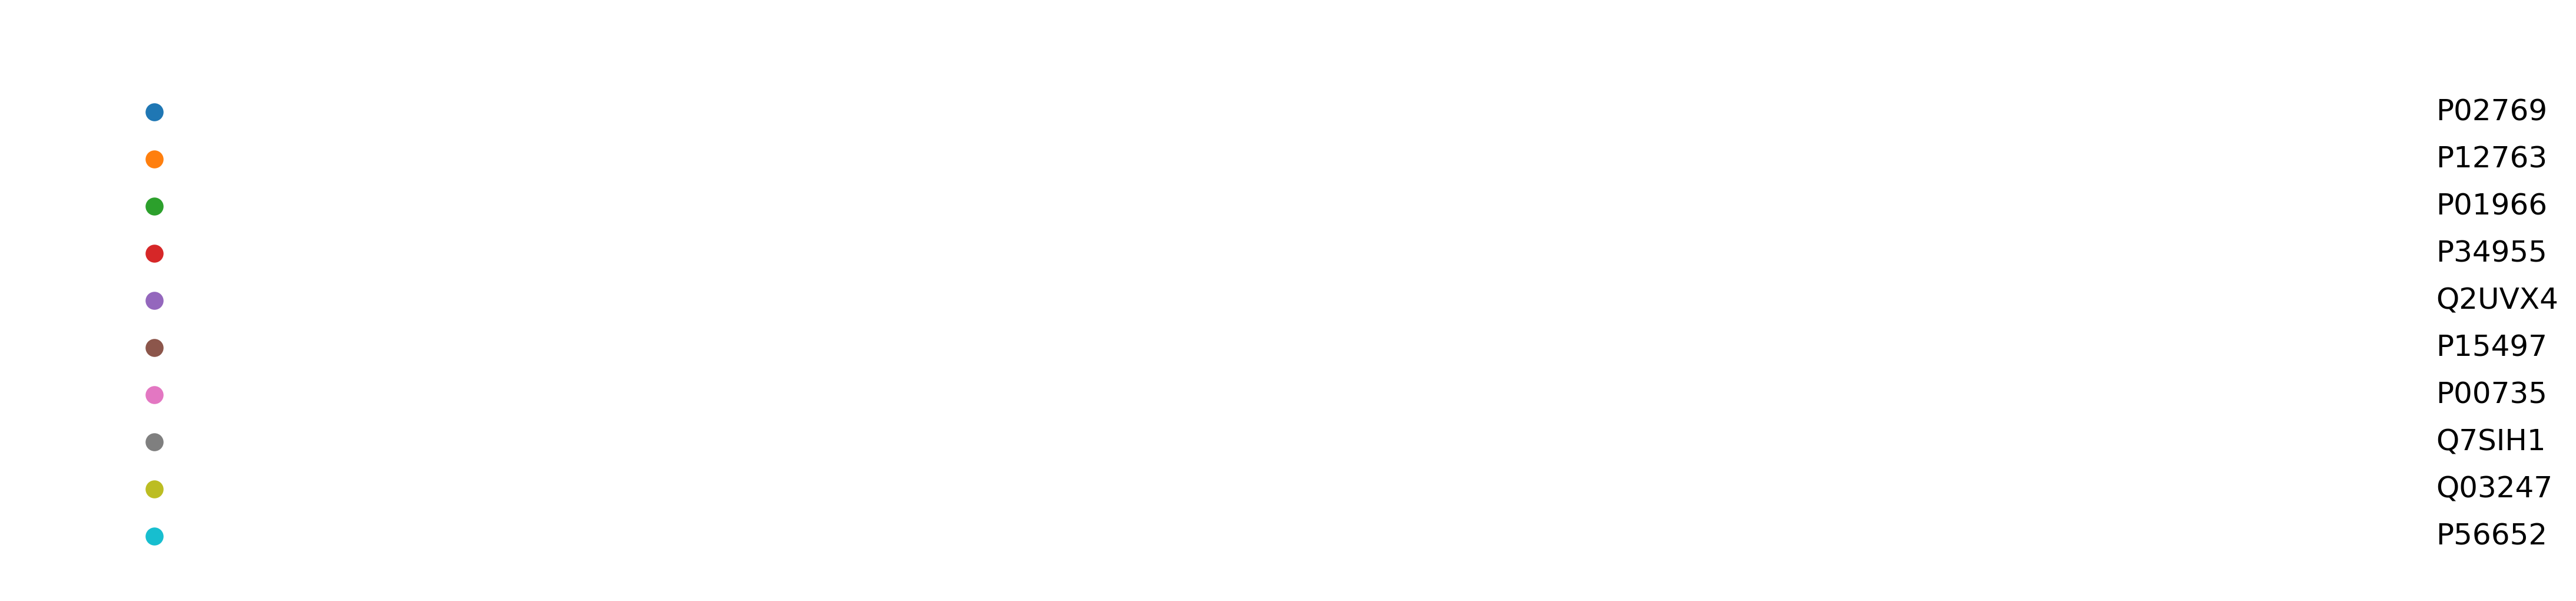

In [ ]:
highlighted_proteins = ['P02769', 'P12763', 'P01966', 'P34955', 'Q2UVX4',
                        'P15497', 'P00735', 'Q7SIH1', 'Q03247', 'P56652']

colors = cm.get_cmap('tab10', len(highlighted_proteins))
protein_color_map = {
    protein: to_hex(colors(i))
    for i, protein in enumerate(highlighted_proteins)
}

fig, ax = plt.subplots(figsize=(2, len(highlighted_proteins) * 0.4), facecolor='white')
plt.axis('off')

for i, protein in enumerate(highlighted_proteins):
    color = protein_color_map[protein]
    y_pos = len(highlighted_proteins) - i
    ax.scatter(0.5, y_pos, color=color, s=40)

    ax.text(1, y_pos, protein, va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

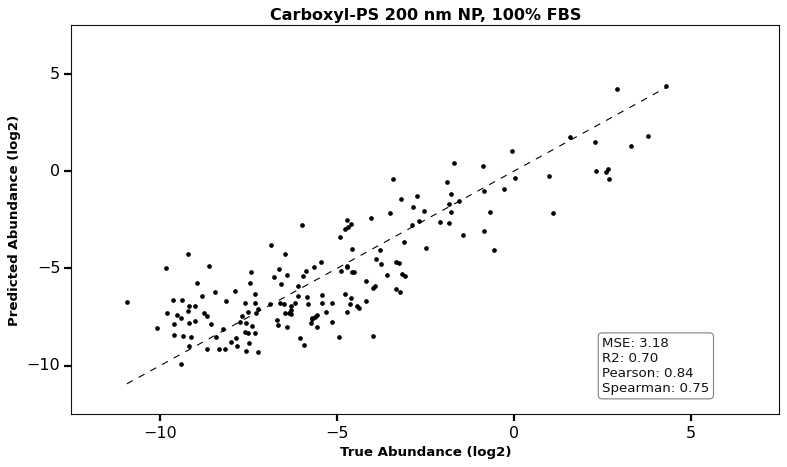

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

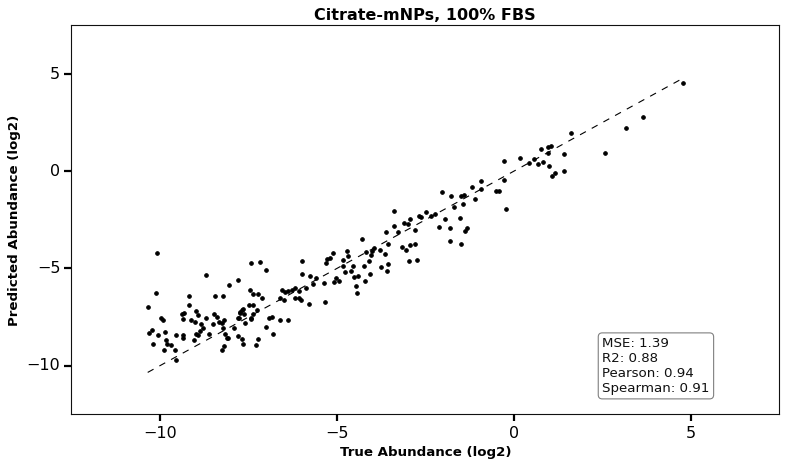

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

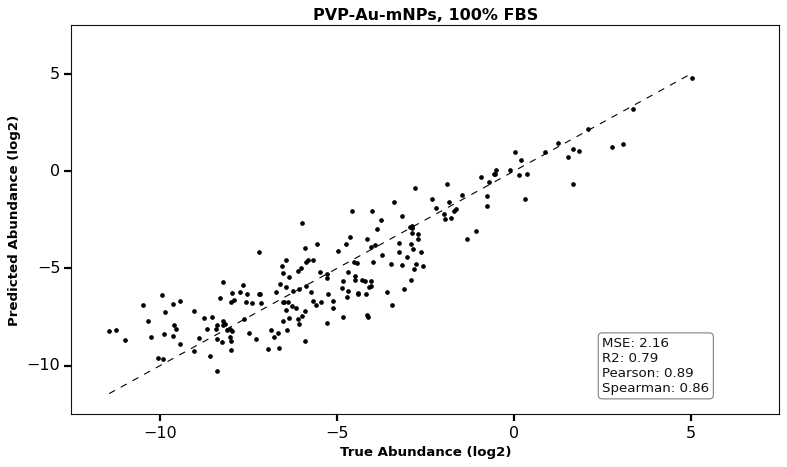

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

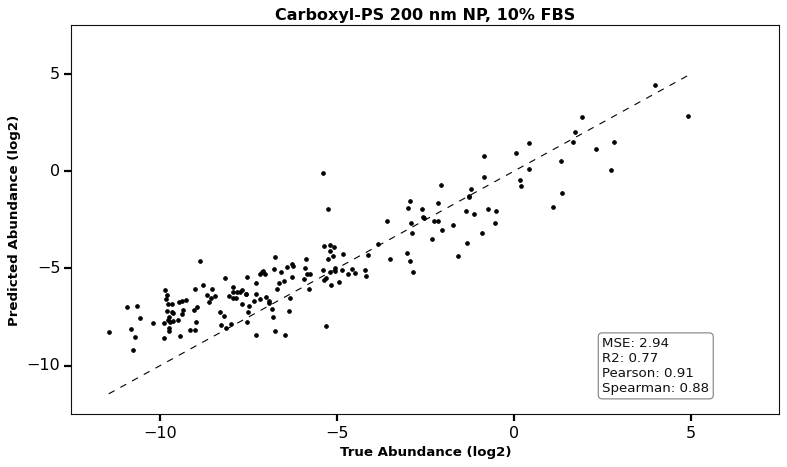

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

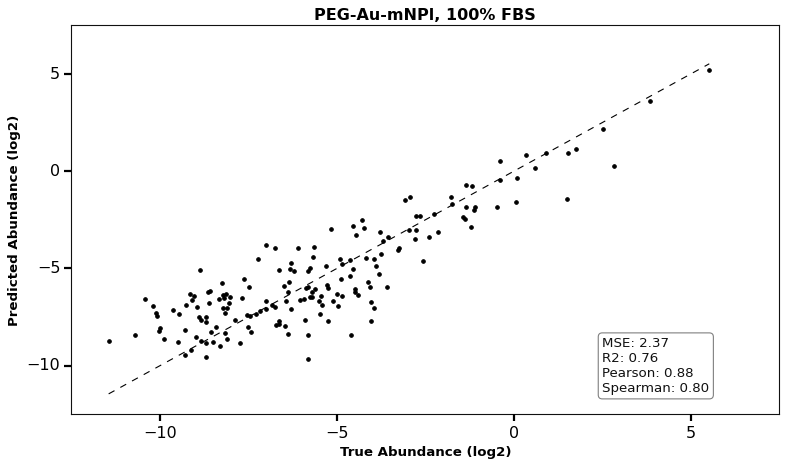

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

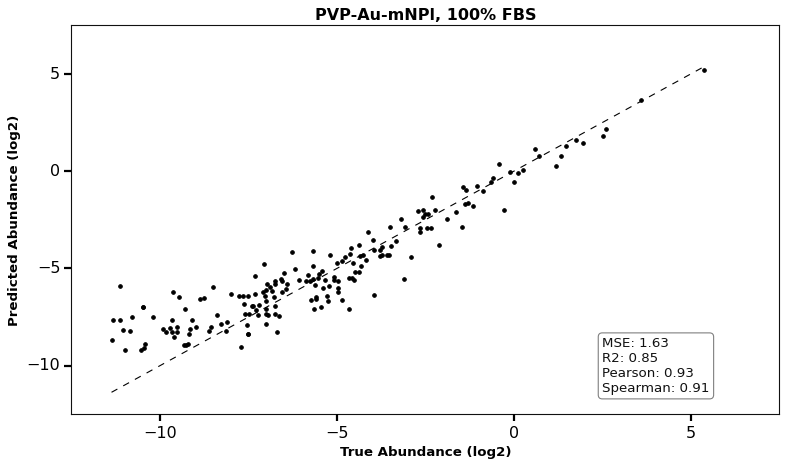

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

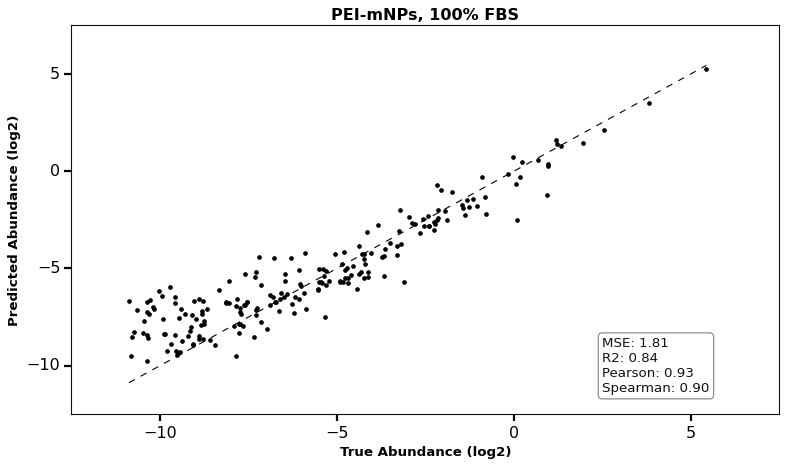

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

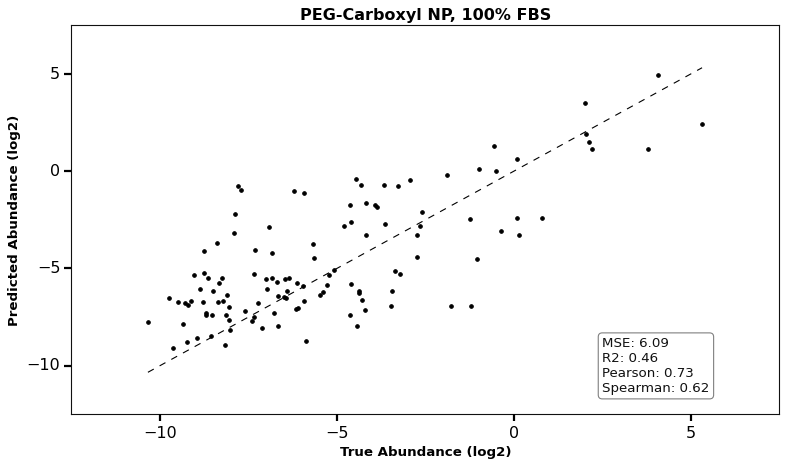

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

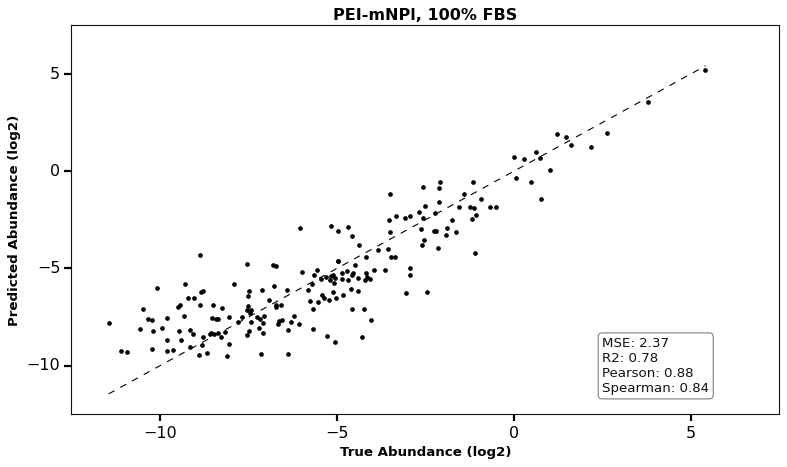

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

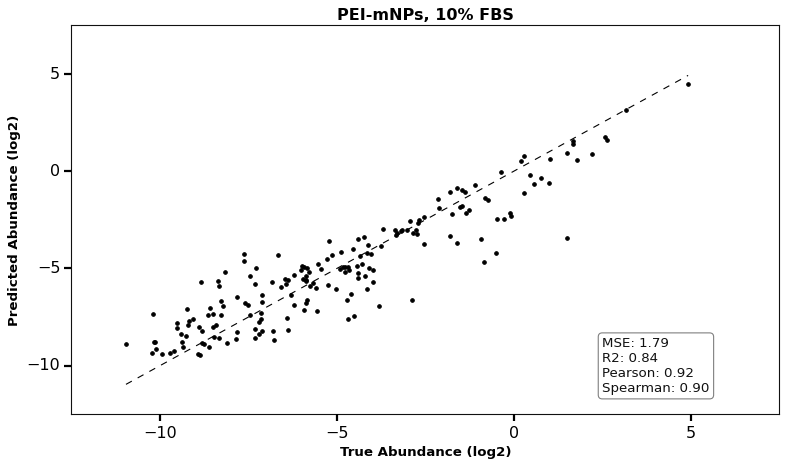

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

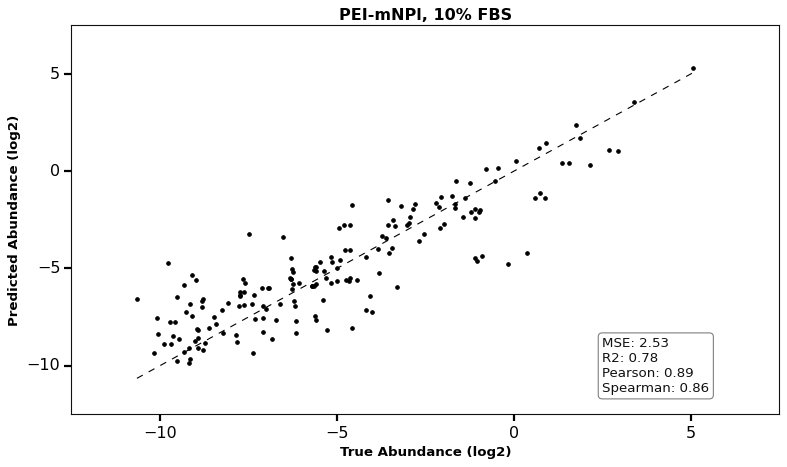

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

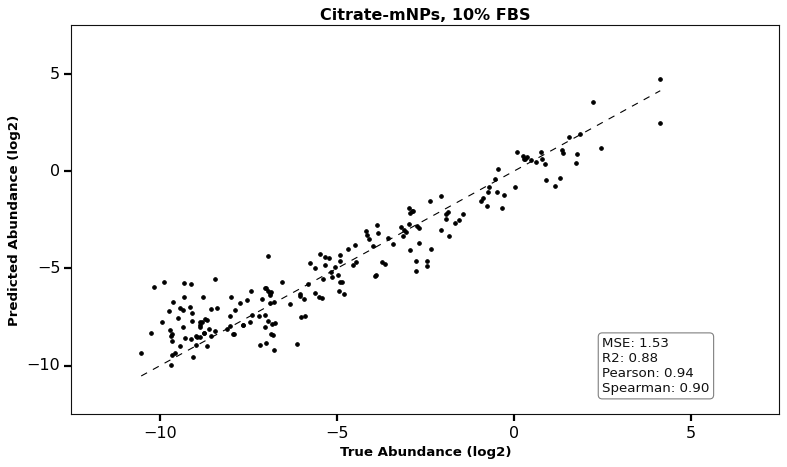

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

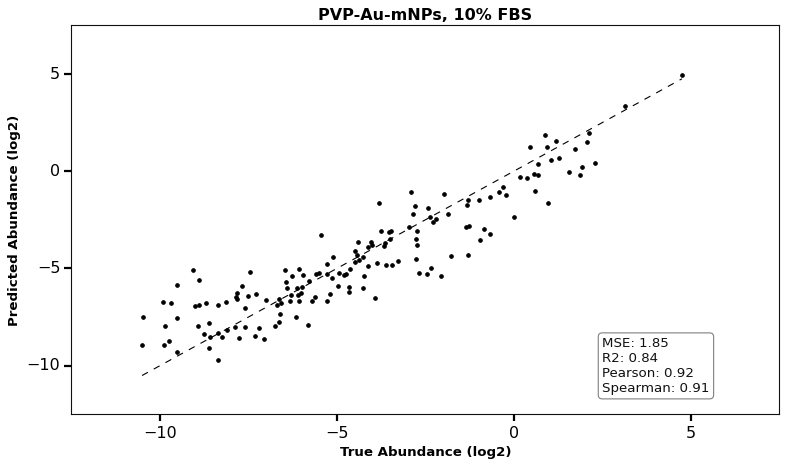

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

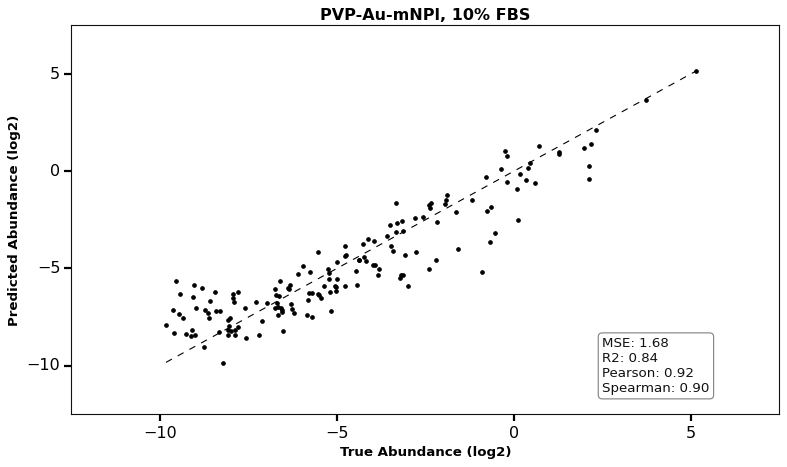

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

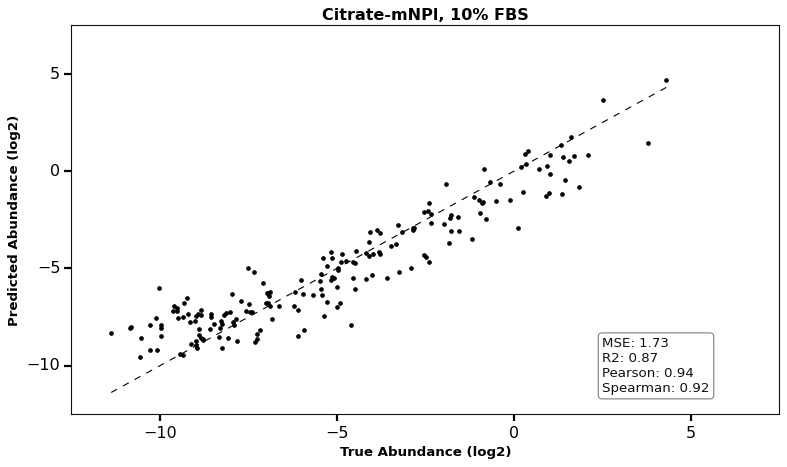

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

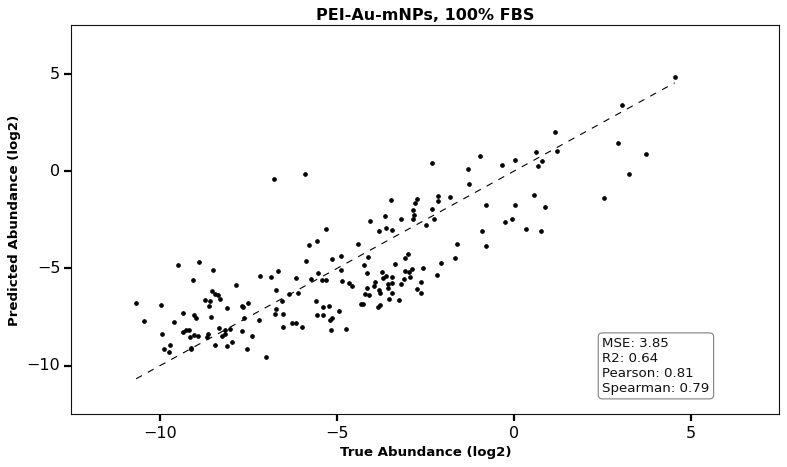

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

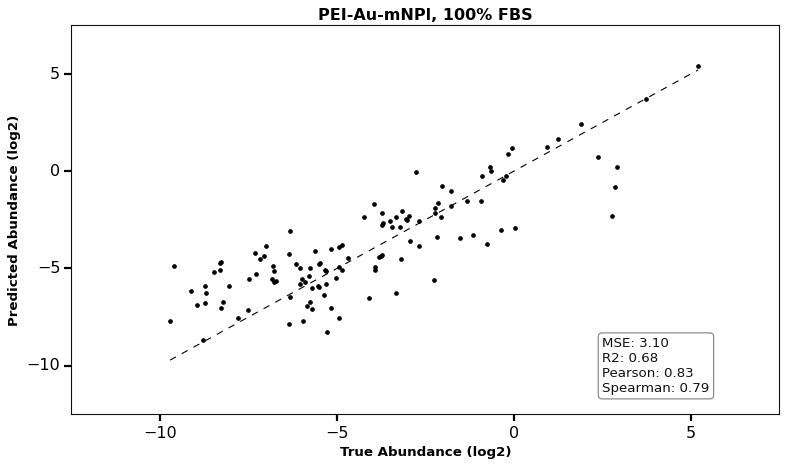

['Abundance_Controls', 'Mass', 'frac_aa_A', 'frac_aa_C', 'frac_aa_D', 'frac_aa_F', 'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_N', 'frac_aa_Q', 'frac_aa_S', 'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight', 'instability_index', 'flexibility_max', 'flexibility_min', 'isoelectric_point', 'secondary_structure_fraction_helix', 'secondary_structure_fraction_sheet', 'secondary_structure_fraction_disordered', 'fraction_exposed', 'fraction_buried', 'fraction_exposed_nonpolar_total', 'fraction_exposed_nonpolar_exposed', 'rsa_std', 'asa_sum', 'fraction_exposed_exposed_A', 'fraction_exposed_exposed_C', 'fraction_exposed_exposed_D', 'fraction_exposed_exposed_E', 'fraction_exposed_exposed_F', 'fraction_exposed_exposed_G', 'fraction_exposed_exposed_H', 'fraction_exposed_exposed_K', 'fraction_exposed_exposed_L', 'fraction_exposed_exposed_M', 'fraction_exposed_exposed_P', 'fraction_exposed_exposed_R', 'fraction_exposed_exposed_S', 'fraction_exposed_exposed_T', 'fraction_expos

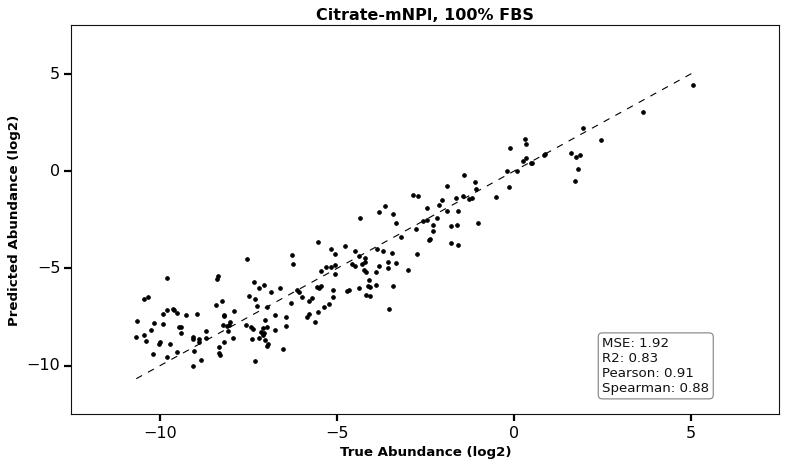

    Pearson  Spearman  R-squared  Mean Squared Error  \
0  0.841107  0.753719   0.701526            3.175243   
0  0.943707  0.910272   0.882897            1.387377   
0  0.890145  0.861736   0.790146            2.160226   
0  0.914334  0.883888   0.771120            2.938107   
0  0.875207  0.796673   0.764250            2.366946   

                                ID  
0  Carboxyl-PS 200 nm NP, 100% FBS  
0           Citrate-mNPs, 100% FBS  
0            PVP-Au-mNPs, 100% FBS  
0   Carboxyl-PS 200 nm NP, 10% FBS  
0            PEG-Au-mNPl, 100% FBS  


In [ ]:
npunid_to_full_name = {
    17: "Carboxyl-PS 200 nm NP, 10% FBS",
    18: "Carboxyl-PS 200 nm NP, 100% FBS",
    19: "Citrate-mNPs, 10% FBS",
    20: "Citrate-mNPl, 10% FBS",
    21: "PEI-mNPs, 10% FBS",
    22: "PEI-mNPl, 10% FBS",
    23: "PVP-Au-mNPl, 100% FBS",
    24: "PVP-Au-mNPs, 10% FBS",
    25: "PVP-Au-mNPs, 100% FBS",
    26: "Citrate-mNPl, 100% FBS",
    27: "PEI-mNPl, 100% FBS",
    28: "Citrate-mNPs, 100% FBS",
    29: "PEI-mNPs, 100% FBS",
    30: "PVP-Au-mNPl, 10% FBS",
    31: "PEG-Au-mNPl, 100% FBS",
    32: "PEI-Au-mNPl, 100% FBS",
    33: "PEI-Au-mNPs, 100% FBS",
    34: "PEG-Carboxyl NP, 100% FBS"
}

def predict_nanoparticles(train_set, test_set, name):
    # Initialize a RFR
    model = RandomForestRegressor(n_estimators=100, random_state = 42)

    # X is df and y is 'Abundance' column in df
    # 'Abundance' column in df represents target value
    label_train = np.log2(train_set['Abundance'].to_numpy().astype(float))

    # Remove unnecessary columns
    #columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'Entry'] if col in train_set.columns]

    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'NPID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'BatchID', 'Protein Source'] if col in train_set.columns]
    train_set.drop(columns=columns_to_drop, inplace=True)
    selected_features = train_set.columns.tolist()
    print(selected_features)
    print(len(selected_features))

    label_pred = np.log2(test_set['Abundance'].to_numpy().astype(float))

    X_train = train_set[selected_features].copy()
    X_test = test_set[selected_features].copy()
    y_train = label_train
    y_test = label_pred

    # Train the RFR
    model.fit(X_train, y_train)

    # Evaluate on test slit (held out NP)
    y_pred = model.predict(X_test)

    # SHAP


    feature_name_dict = {
          'Abundance_Controls' : 'Control Abundance',
          'frac_aa_A': '% Amino Acid - Alanine (A)',
          'frac_aa_C': '% Amino Acid - Cysteine (C)',
          'frac_aa_D': '% Amino Acid - Aspartic Acid (D)',
          'frac_aa_E': '% Amino Acid - Glutamic Acid (E)',
          'frac_aa_F': '% Amino Acid - Phenylalanine (F)',
          'frac_aa_G': '% Amino Acid - Glycine (G)',
          'frac_aa_H': '% Amino Acid - Histidine (H)',
          'frac_aa_I': '% Amino Acid - Isoleucine (I)',
          'frac_aa_K': '% Amino Acid - Lysine (K)',
          'frac_aa_L': '% Amino Acid - Leucine (L)',
          'frac_aa_M': '% Amino Acid - Methionine (M)',
          'frac_aa_N': '% Amino Acid - Asparagine (N)',
          'frac_aa_P': '% Amino Acid - Proline (P)',
          'frac_aa_Q': '% Amino Acid - Glutamine (Q)',
          'frac_aa_R': '% Amino Acid - Arginine (R)',
          'frac_aa_S': '% Amino Acid - Serine (S)',
          'frac_aa_T': '% Amino Acid - Threonine (T)',
          'frac_aa_V': '% Amino Acid - Valine (V)',
          'frac_aa_W': '% Amino Acid - Tryptophan (W)',
          'frac_aa_Y': '% Amino Acid - Tyrosine (Y)',
          'gravy': 'GRAVY score',
          'aromaticity': 'Aromaticity',
          'instability_index': 'Instability Index',
          'flexibility_mean': 'Flexibility - Mean',
          'flexibility_std': 'Flexibility - Standard Deviation',
          'flexibility_max': 'Flexibility - Max',
          'flexibility_min': 'Flexibility - Min',
          'isoelectric_point': 'Isoelectric Point',
          'secondary_structure_fraction_helix': '% Secondary Structure-Associated\n Amino Acids – Helix',
          'secondary_structure_fraction_turn': '% Secondary Structure-Associated\n Amino Acids – Turn',
          'secondary_structure_fraction_sheet': '% Secondary Structure-Associated\n Amino Acids – Sheet',
          'secondary_structure_fraction_disordered': '% Secondary Structure-Associated\n Amino Acids - Non-Structure Associated',
          'length': 'Length',
          'molecular_weight': 'Molecular Weight',
          'fraction_exposed': '% Amino Acids Exposed',
          'fraction_buried': '% Amino Acids Buried',
          'fraction_exposed_nonpolar_total': '% Exposed Nonpolar Amino Acids\n / Total Amino Acids',
          'fraction_exposed_nonpolar_exposed': '% Exposed Nonpolar Amino Acids\n / Total Exposed',
          'fraction_exposed_polar_total': '% Exposed Polar Amino Acids\n / Total Amino Acids',
          'fraction_exposed_polar_exposed': '% Exposed Polar Amino Acids\n / Total Exposed',
          'rsa_mean': 'Relative Surface Area (RSA) - Mean',
          'rsa_std': 'Relative Surface Area - Standard Deviation',
          'asa_sum': 'Absolute Surface Area (ASA) - Sum',
          'fraction_exposed_exposed_A': '% Exposed Amino Acid A\n / Total Exposed',
          'fraction_exposed_exposed_C': '% Exposed Amino Acid C\n / Total Exposed',
          'fraction_exposed_exposed_D': '% Exposed Amino Acid D\n / Total Exposed',
          'fraction_exposed_exposed_E': '% Exposed Amino Acid E\n / Total Exposed',
          'fraction_exposed_exposed_F': '% Exposed Amino Acid F\n / Total Exposed',
          'fraction_exposed_exposed_G': '% Exposed Amino Acid G\n / Total Exposed',
          'fraction_exposed_exposed_H': '% Exposed Amino Acid H\n / Total Exposed',
          'fraction_exposed_exposed_I': '% Exposed Amino Acid I\n / Total Exposed',
          'fraction_exposed_exposed_K': '% Exposed Amino Acid K\n / Total Exposed',
          'fraction_exposed_exposed_L': '% Exposed Amino Acid L\n / Total Exposed',
          'fraction_exposed_exposed_M': '% Exposed Amino Acid M\n / Total Exposed',
          'fraction_exposed_exposed_N': '% Exposed Amino Acid N\n / Total Exposed',
          'fraction_exposed_exposed_P': '% Exposed Amino Acid P\n / Total Exposed',
          'fraction_exposed_exposed_Q': '% Exposed Amino Acid Q\n / Total Exposed',
          'fraction_exposed_exposed_R': '% Exposed Amino Acid R\n / Total Exposed',
          'fraction_exposed_exposed_S': '% Exposed Amino Acid S\n / Total Exposed',
          'fraction_exposed_exposed_T': '% Exposed Amino Acid T\n / Total Exposed',
          'fraction_exposed_exposed_V': '% Exposed Amino Acid V\n / Total Exposed',
          'fraction_exposed_exposed_W': '% Exposed Amino Acid W\n / Total Exposed',
          'fraction_exposed_exposed_Y': '% Exposed Amino Acid Y\n / Total Exposed',
          'nsp_secondary_structure_helix': '% Secondary Structure\n - Helix',
          'nsp_secondary_structure_sheet': '% Secondary Structure\n - Sheet',
          'nsp_secondary_structure_coiled': '% Secondary Structure\n - Coil',
          'nsp_disordered': '% Secondary Structure - Disordered',
          'Dh_functionalized': 'NP Hydrodynamic Diameter',
          'Dtem': 'NP TEM Diameter'
    }

    original_column_names = X_test.columns

    # SHAP evaluation of feature section
    # X_train_graph = X_train.copy()
    # X_test_graph = X_test.copy()
    # X_train_graph.columns = [feature_name_dict.get(col, col) for col in original_column_names]
    # X_test_graph.columns = [feature_name_dict.get(col, col) for col in original_column_names]

    # explainer = shap.Explainer(model, X_train_graph)
    # shap_values = explainer(X_test_graph, check_additivity=False)
    # #shap.summary_plot(shap_values, X_test_graph, plot_type="bar", show=False)
    # shap.summary_plot(shap_values, X_test_graph, show=False)
    # #plt.grid(False)

    # plt.gca().tick_params(axis='y', labelsize=5)
    # plt.tight_layout()
    # plt.show()
    # explainer = shap.Explainer(model, X_train)
    # shap_values = explainer(X_test, check_additivity=False)
    # shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    # shap.summary_plot(shap_values, X_test)

    # Calculate evaluation metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Create a scatter plot of true vs predicted values
    plt.style.use('classic')
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
    plt.rcParams['figure.dpi'] = 300

    # Scatter plot of true vs. predicted values using adjusted color and marker size
    ax.scatter(y_test, y_pred, color='black', s=10)  # Using black for consistency and adjusting marker size

    # Identity line with adjusted color and line style
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')

    # Setting labels, title with customized options
    ax.set_xlabel('True Abundance (log2)', fontweight='bold', color='black')
    ax.set_ylabel('Predicted Abundance (log2)', fontweight='bold', color='black')
    ax.set_title(f"{name}", fontweight='bold', color='black')
    ax.set_xlim(left=-12.5, right=7.5)
    ax.set_ylim(bottom=-12.5, top=7.5)

    # Add a metrics box to the plot with consistent styling
    box_text = f"MSE: {mse:.2f}\nR2: {r_squared:.2f}\nPearson: {pearson:.2f}\nSpearman: {spearman:.2f}"
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.5)
    ax.text(0.75, 0.05, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

    ax.tick_params(axis='both', which='both', direction='out',
                   length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black',
                   bottom=True, top=False, left=True, right=False)

    # Remove grid lines for a cleaner look
    ax.grid(False)

    plt.tight_layout()
    plt.show()
    plt.close()

    ### testing space

    nps = test_set['NPUNID'] if 'NPUNID' in test_set.columns else None
    proteins = test_set['Entry'] if 'Entry' in test_set.columns else None

    # Save results for individual proteins and nanoparticles
    results_proteins = pd.DataFrame({
        'NPUNID': nps,
        'Protein': proteins,
        'True Abundance (log2)': y_test,
        'Predicted Abundance (log2)': y_pred
    })

    # Save results to an Excel file
    #output_file = f"/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/{name}_parity_plot_data_predict.xlsx"
    #results_proteins.to_excel(output_file, index=False)
    #print(f"Saved parity plot data for {name} to {output_file}")


    results = pd.DataFrame({
        "Pearson": [pearson],
        "Spearman": [spearman],
        "R-squared": [r_squared],
        "Mean Squared Error": [mse],
        "ID": name
    })

    return results



# Manually selected file for 1) original (cleaned) df to get a hold of ALL data
original_df = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/df_Bov Swiss Intensity_v1.xlsx'
feats_from_rfr_rfecv = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_Bov SP Intensity _v1.xlsx'

df = pd.read_excel(original_df, header=0)
df_feats = pd.read_excel(feats_from_rfr_rfecv, header=0)

# Extract the list of column names from df_feats
feats_columns = df_feats.columns.tolist()
print(feats_columns)

# Filter df to only include the columns that match feats_columns, making a copy
df_filtered = df[feats_columns].copy()
# Create new evaluation df that will have the results of everything appended to it
full_eval = pd.DataFrame()

# Create a list of all unique NPUNID IDs in current df
np_ids = df['NPUNID'].unique().tolist()
print(np_ids)


for np_id in np_ids:
    # Filter df to only include rows with current NPUNID - test set
    current_np = df_filtered.loc[df['NPUNID'] == np_id].copy()
    # Filter df to only include rows without current NPUNID - train set
    temp_df = df_filtered.loc[df['NPUNID'] != np_id].copy()

    # Get full sample name
    full_name = npunid_to_full_name.get(np_id, f'ID: {np_id}')

    # Train RFR model to make predictions on current NPUNID entry
    eval = predict_nanoparticles(temp_df, current_np, full_name)

    # Append the test to the full evaluation df
    full_eval = pd.concat([full_eval, eval])

print(full_eval.head())